# CE-40959: Deep Learning
## HW5 - Variational Autoencoder
#### 35 Points | Deadline: 4th of Khordad

---

Name: 
Seyed Shayan Nazemi


Student No.: 
98209037


---

**!!! CAUTION !!!**

To prevent Colab from disconnecting, insert the following javascript code into the inspector's console.

More info: 
[medium](https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0),
[stackoverflow](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)



```
function ClickConnect(){
  console.log("Working"); 
  document
    .querySelector("#top-toolbar > colab-connect-button")
    .shadowRoot
    .querySelector("#connect")
    .click()
}

setInterval(ClickConnect,60000)
```


In [0]:
#################### Problem 00 ####################
# Remember to write your Name and Student No. in the first cell :D
####################### End ########################

In [0]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm.auto import tqdm, trange

%matplotlib inline

In [0]:
LOG_INTERVAL = 200

BATCH_SIZE = 128
LEARNING_RATE = 5e-5

CUDA = True
device = torch.device("cuda" if CUDA else "cpu")

In [0]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1) Helper functions

In [0]:
def show(images, rows=1):
    """
    This function gets multiple MNIST images and plots them in the given number
    of rows.
    """
    if images.shape[-1] == 784 or images.shape[1] == 1:
        images = images.reshape(-1, 28, 28)

    cols = np.ceil(images.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (cols, rows)
    
    for i in range(images.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

## 2) Loading dataset

In [31]:
# Get MNIST dataloader

data_loader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 4,
}

train_dataset = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **data_loader_kwargs)

print(train_dataset.data.max().item())  # But when using `train_loader` your data is normalized, learn more about transforms.ToTensor

255


## 3) Models

### 3.1) Autoencoder (7 pts)

In [0]:
# This class defines an Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(AE, self).__init__()

        self.type_str = 'AE'
        self.z_dim = z_dim
        self.dropout = nn.Dropout(p=0.2)
        
        # Encoder part
        encoder_layers = list()
        ############### Problem 01 (2 pts) ################
        # Iterate over `encoder_dims` and create fully connected layers
        # Use ReLU activation function after each FC layer
        # Append all layers to `encoder_layers`
        layers = [input_dim, *encoder_dims]
        for idx, layer_dim in enumerate(layers):
            if idx < len(layers) - 1:
                encoder_layers.append(nn.Linear(layer_dim, layers[idx + 1]))
                encoder_layers.append(nn.ReLU())
        pass
        ####################### End ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Compute Z
        self.z_layer = None
        ################ Problem 02 (1 pts) ################
        # Define a fully connected layer that maps the output of previous part
        # to `z_dim` dimensions, store it in `self.z_layer`
        # No activation function is needed after this layer
        self.z_layer = nn.Linear(layers[-1], z_dim)
        pass
        ####################### End ########################

        # Decoder part
        decoder_layers = list()
        ################ Problem 03 (2 pts) ################
        layers = [z_dim, *decoder_dims]
        for idx, layer_dim in enumerate(layers):
            if idx < len(layers) - 1:
                decoder_layers.append(nn.Linear(layer_dim, layers[idx + 1]))
                decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(decoder_dims[-1], input_dim))
        # Define the decoder part (Use `decoder_dims`)
        # Use ReLU activation function after each FC layer (except the last one)
        # The last layer output should be of `input_dim` size
        # Append all layers to `decoder_layers`
        pass
        ####################### End ########################
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x_hat, z = None, None
        dropped_out = self.dropout(x)
        ################ Problem 04 (1 pts) ################
        # Do the forward pass
        # Compute `x_hat` (reconstructed inputs), and `z` (the latent variables)

        encoded = self.encoder(dropped_out)
        z = self.z_layer(encoded)
        x_hat = self.decoder(z)

        pass
        ####################### End ########################
        return x_hat, z, None  # Last output is returned for the sake of compatibility

    def get_loss(self, x, x_hat, *_):
        ################ Problem 05 (1 pts) ################
        # Compute and return the MSE between x and x_hat
        return F.mse_loss(x, x_hat, reduction='sum')
        ####################### End ########################

### 3.2) Variational Autoencoder (10 pts)

In [0]:
# This class defines a Variationl Autoencoder
# It inherits the AE class
class VAE(AE):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims):
        super(VAE, self).__init__(input_dim, encoder_dims, z_dim, decoder_dims)

        self.type_str = 'VAE'
        del self.z_layer  # z_layer is not needed anymore

        # Drouput, Encoder, and Decoder have been defined in AE class

        # mu and sigma_matrix part
        self.mu_layer, self.logvar_layer = None, None
        ################ Problem 06 (1 pts) ################
        # Define mu and logvar layers
        # Notice that we should have a logvar_layer, not a sigma_layer
        # Do not use any activation function
        self.mu_layer = nn.Linear(encoder_dims[-1], z_dim)
        self.logvar_layer = nn.Linear(encoder_dims[-1], z_dim)
        pass
        ####################### End ########################

    @staticmethod
    def reparameterize(mu, logvar):
        z = None
        ################ Problem 07 (3 pts) ################
        # Sample `z` from N(`mu`, e^`logvar`) in a way that the gradient can
        # backpropagate through this sampling operation
        
        z = torch.exp(logvar / 2) * torch.randn_like(logvar) + mu
        pass
        ####################### End ########################
        return z

    def forward(self, x):
        x_hat, mu, logvar = None, None, None
        dropped_out = self.dropout(x)
        ################ Problem 08 (1 pts) ################
        # Do the forward pass
        # Compute `x_hat` (reconstructed inputs), `mu`, and `logvar` (outputs of
        # `mu_layer` and `logvar_layer` respectively)
        # Use reparameterization trick (the function you have implemented)
        encoded = self.encoder(dropped_out)
        
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)

        z = self.reparameterize(mu, logvar)

        x_hat = self.decoder(z)
        pass
        ####################### End ########################
        return x_hat, mu, logvar
    
    def get_loss(self, x, x_hat, mu, logvar):
        MSE, KLD = 0, 0
        ################ Problem 09 (3 pts) ################
        # Compute the VAE loss (Assuming Guassian distribution for the decoder
        # output)
        MSE = F.mse_loss(x, x_hat, reduction='sum')
        KLD = torch.sum(mu.pow(2) + logvar.exp() - logvar - 1) / 2
        pass
        ####################### End ########################
        return MSE + KLD

    def generate(self, n):
        samples = None
        ################ Problem 10 (2 pts) ################
        # Generate `n` random noises from N(0, I), feed it into the decoder and
        # generate `n` samples
        noises = torch.normal(mean=0, std=1, size=(n, self.z_dim), device=device)
        samples = self.decoder(noises)
        pass
        ####################### End ########################
        return samples

## 4) Run

### 4.1) Required functions (2 pts)

In [0]:
def train(model, optimizer, verbose=True):
    """
    This function trains a `model` on `train_loader` for 1 epoch and prints the
    loss value
    """
    model.train()
    train_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc='Batches', leave=False)):
        x = x.flatten(start_dim=1).to(device)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = model.get_loss(x, x_hat, mu, logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
            print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * x.shape[0], len(train_loader.dataset), loss.item() / x.shape[0]))

    train_loss /= len(train_loader.dataset)
    if verbose:
        print('==> Train | Average loss: %.4f' % train_loss)

In [0]:
def test(model, verbose=True):
    """
    This function tests a `model` on a `test_loader` and prints the loss value
    """
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.flatten(start_dim=1).to(device)
            
            x_hat, mu, logvar = model(x)
            loss = model.get_loss(x, x_hat, mu, logvar)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)

In [0]:
def run(model, n_epoch, verbose=True):
    """
    This function will optimize parameters of `model` for `n_epoch` epochs
    on `train_loader` and validate it on `test_loader`.
    """
    ################ Problem 11 (1 pts) ################
    # Send `model` to the desired device, defined in `device`
    model.to(device)
    pass
    ####################### End ########################

    optimizer = None
    ################ Problem 12 (1 pts) ################
    # Initialize a new Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    pass
    ####################### End ########################

    for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train(model, optimizer, verbose)
        test(model, verbose)

### 4.2) Do run (1 pts)

In [53]:
ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim = 4 * [None]
################ Problem 13 (1 pts) ################
# Define 4 models, with these specifications:
# name           z_dim   encoder_dims    decoder_dims    training_n_epoch
# ae_low_dim     2       3 layers        3 layers        a
# vae_low_dim    2       same as above   same as above   a
# ae_high_dim    >= 20   3 layers        3 layers        b
# vae_high_dim   >= 20   same as above   same as above   b
# `a`, `b`, `encoder_dims`, and `decoder_dims` of your choice
# Then train all of 4 models

INPUT_SIZE = 784

## 'ae_low_dim' & 'vae_low_dim' models
a = 100
encoder_dims = [256, 64, 16]
z_dim = 2
decoder_dims = [16, 64, 256]

ae_low_dim = AE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)
vae_low_dim = VAE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)



## 'ae_high_dim' & 'vae_high_dim' models
b = 100
encoder_dims = [256, 128, 64]
z_dim = 32
decoder_dims = [64, 128, 256]

ae_high_dim = AE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)
vae_high_dim = VAE(INPUT_SIZE, encoder_dims, z_dim, decoder_dims)



## Training
print('\n\n\nTraining ae_low_dim begin')
run(ae_low_dim, a)
print('\n\n\nTraining vae_low_dim begin')
run(vae_low_dim, a)

print('\n\n\nTraining ae_high_dim begin')
run(ae_high_dim, b)
print('\n\n\nTraining vae_high_dim begin')
run(vae_high_dim, b)

pass
####################### End ########################

models = [ae_low_dim, vae_low_dim, ae_high_dim, vae_high_dim]




Training ae_low_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 50.60581
    Train [51072/60000]	 | 	Loss: 49.25620
==> Train | Average loss: 57.8608
==> Test  | Average loss: 48.2214

Epoch 2:


    Train [25472/60000]	 | 	Loss: 44.26444
    Train [51072/60000]	 | 	Loss: 46.37964
==> Train | Average loss: 45.7820
==> Test  | Average loss: 44.6152

Epoch 3:


    Train [25472/60000]	 | 	Loss: 42.99419
    Train [51072/60000]	 | 	Loss: 43.00797
==> Train | Average loss: 43.9475
==> Test  | Average loss: 43.1811

Epoch 4:


    Train [25472/60000]	 | 	Loss: 43.40659
    Train [51072/60000]	 | 	Loss: 38.69290
==> Train | Average loss: 42.8668
==> Test  | Average loss: 42.3458

Epoch 5:


    Train [25472/60000]	 | 	Loss: 40.49413
    Train [51072/60000]	 | 	Loss: 43.24861
==> Train | Average loss: 42.2874
==> Test  | Average loss: 41.9027

Epoch 6:


    Train [25472/60000]	 | 	Loss: 43.73901
    Train [51072/60000]	 | 	Loss: 40.54934
==> Train | Average loss: 41.8685
==> Test  | Average loss: 41.4759

Epoch 7:


    Train [25472/60000]	 | 	Loss: 39.87976
    Train [51072/60000]	 | 	Loss: 41.80317
==> Train | Average loss: 41.4889
==> Test  | Average loss: 41.1091

Epoch 8:


    Train [25472/60000]	 | 	Loss: 41.50717
    Train [51072/60000]	 | 	Loss: 39.92506
==> Train | Average loss: 41.1150
==> Test  | Average loss: 40.7396

Epoch 9:


    Train [25472/60000]	 | 	Loss: 40.51042
    Train [51072/60000]	 | 	Loss: 39.59028
==> Train | Average loss: 40.7002
==> Test  | Average loss: 40.2992

Epoch 10:


    Train [25472/60000]	 | 	Loss: 39.40271
    Train [51072/60000]	 | 	Loss: 39.71495
==> Train | Average loss: 40.2724
==> Test  | Average loss: 39.9026

Epoch 11:


    Train [25472/60000]	 | 	Loss: 38.08974
    Train [51072/60000]	 | 	Loss: 41.29748
==> Train | Average loss: 39.8564
==> Test  | Average loss: 39.4968

Epoch 12:


    Train [25472/60000]	 | 	Loss: 40.72210
    Train [51072/60000]	 | 	Loss: 39.16228
==> Train | Average loss: 39.4381
==> Test  | Average loss: 39.1188

Epoch 13:


    Train [25472/60000]	 | 	Loss: 42.31656
    Train [51072/60000]	 | 	Loss: 39.01483
==> Train | Average loss: 39.0104
==> Test  | Average loss: 38.6479

Epoch 14:


    Train [25472/60000]	 | 	Loss: 39.04008
    Train [51072/60000]	 | 	Loss: 38.32953
==> Train | Average loss: 38.5328
==> Test  | Average loss: 38.2551

Epoch 15:


    Train [25472/60000]	 | 	Loss: 35.93019
    Train [51072/60000]	 | 	Loss: 40.15882
==> Train | Average loss: 38.0976
==> Test  | Average loss: 37.8315

Epoch 16:


    Train [25472/60000]	 | 	Loss: 37.11122
    Train [51072/60000]	 | 	Loss: 37.97720
==> Train | Average loss: 37.7100
==> Test  | Average loss: 37.3505

Epoch 17:


    Train [25472/60000]	 | 	Loss: 36.03442
    Train [51072/60000]	 | 	Loss: 37.06512
==> Train | Average loss: 37.3679
==> Test  | Average loss: 37.0164

Epoch 18:


    Train [25472/60000]	 | 	Loss: 35.94654
    Train [51072/60000]	 | 	Loss: 39.22523
==> Train | Average loss: 37.0621
==> Test  | Average loss: 36.7153

Epoch 19:


    Train [25472/60000]	 | 	Loss: 38.30710
    Train [51072/60000]	 | 	Loss: 36.54011
==> Train | Average loss: 36.7855
==> Test  | Average loss: 36.5124

Epoch 20:


    Train [25472/60000]	 | 	Loss: 35.29549
    Train [51072/60000]	 | 	Loss: 37.23145
==> Train | Average loss: 36.5146
==> Test  | Average loss: 36.2326

Epoch 21:


    Train [25472/60000]	 | 	Loss: 36.80587
    Train [51072/60000]	 | 	Loss: 36.68266
==> Train | Average loss: 36.2966
==> Test  | Average loss: 36.0689

Epoch 22:


    Train [25472/60000]	 | 	Loss: 37.03855
    Train [51072/60000]	 | 	Loss: 35.33743
==> Train | Average loss: 36.1000
==> Test  | Average loss: 35.8181

Epoch 23:


    Train [25472/60000]	 | 	Loss: 35.76811
    Train [51072/60000]	 | 	Loss: 37.79215
==> Train | Average loss: 35.9152
==> Test  | Average loss: 35.6679

Epoch 24:


    Train [25472/60000]	 | 	Loss: 37.68967
    Train [51072/60000]	 | 	Loss: 36.19611
==> Train | Average loss: 35.7407
==> Test  | Average loss: 35.4786

Epoch 25:


    Train [25472/60000]	 | 	Loss: 34.35530
    Train [51072/60000]	 | 	Loss: 35.58694
==> Train | Average loss: 35.5758
==> Test  | Average loss: 35.3406

Epoch 26:


    Train [25472/60000]	 | 	Loss: 35.51689
    Train [51072/60000]	 | 	Loss: 34.81688
==> Train | Average loss: 35.4350
==> Test  | Average loss: 35.2076

Epoch 27:


    Train [25472/60000]	 | 	Loss: 38.44060
    Train [51072/60000]	 | 	Loss: 34.27436
==> Train | Average loss: 35.3037
==> Test  | Average loss: 35.0788

Epoch 28:


    Train [25472/60000]	 | 	Loss: 35.76204
    Train [51072/60000]	 | 	Loss: 33.89247
==> Train | Average loss: 35.1644
==> Test  | Average loss: 34.9876

Epoch 29:


    Train [25472/60000]	 | 	Loss: 35.98391
    Train [51072/60000]	 | 	Loss: 34.80108
==> Train | Average loss: 35.0549
==> Test  | Average loss: 34.8681

Epoch 30:


    Train [25472/60000]	 | 	Loss: 35.55054
    Train [51072/60000]	 | 	Loss: 33.91208
==> Train | Average loss: 34.9418
==> Test  | Average loss: 34.7761

Epoch 31:


    Train [25472/60000]	 | 	Loss: 36.56422
    Train [51072/60000]	 | 	Loss: 32.92027
==> Train | Average loss: 34.8425
==> Test  | Average loss: 34.6650

Epoch 32:


    Train [25472/60000]	 | 	Loss: 33.76736
    Train [51072/60000]	 | 	Loss: 33.53723
==> Train | Average loss: 34.7417
==> Test  | Average loss: 34.6154

Epoch 33:


    Train [25472/60000]	 | 	Loss: 34.11199
    Train [51072/60000]	 | 	Loss: 31.86373
==> Train | Average loss: 34.6458
==> Test  | Average loss: 34.4719

Epoch 34:


    Train [25472/60000]	 | 	Loss: 35.08334
    Train [51072/60000]	 | 	Loss: 35.25113
==> Train | Average loss: 34.5625
==> Test  | Average loss: 34.4122

Epoch 35:


    Train [25472/60000]	 | 	Loss: 35.18925
    Train [51072/60000]	 | 	Loss: 33.69149
==> Train | Average loss: 34.4776
==> Test  | Average loss: 34.3067

Epoch 36:


    Train [25472/60000]	 | 	Loss: 35.30314
    Train [51072/60000]	 | 	Loss: 33.40267
==> Train | Average loss: 34.3861
==> Test  | Average loss: 34.1869

Epoch 37:


    Train [25472/60000]	 | 	Loss: 34.62912
    Train [51072/60000]	 | 	Loss: 33.23059
==> Train | Average loss: 34.3016
==> Test  | Average loss: 34.1157

Epoch 38:


    Train [25472/60000]	 | 	Loss: 34.40348
    Train [51072/60000]	 | 	Loss: 32.23915
==> Train | Average loss: 34.2304
==> Test  | Average loss: 34.0534

Epoch 39:


    Train [25472/60000]	 | 	Loss: 32.64851
    Train [51072/60000]	 | 	Loss: 34.00423
==> Train | Average loss: 34.1522
==> Test  | Average loss: 33.9657

Epoch 40:


    Train [25472/60000]	 | 	Loss: 33.58701
    Train [51072/60000]	 | 	Loss: 33.69518
==> Train | Average loss: 34.0774
==> Test  | Average loss: 33.8849

Epoch 41:


    Train [25472/60000]	 | 	Loss: 34.20590
    Train [51072/60000]	 | 	Loss: 32.16581
==> Train | Average loss: 34.0063
==> Test  | Average loss: 33.8413

Epoch 42:


    Train [25472/60000]	 | 	Loss: 32.51419
    Train [51072/60000]	 | 	Loss: 34.27633
==> Train | Average loss: 33.9257
==> Test  | Average loss: 33.7505

Epoch 43:


    Train [25472/60000]	 | 	Loss: 32.27916
    Train [51072/60000]	 | 	Loss: 34.23104
==> Train | Average loss: 33.8449
==> Test  | Average loss: 33.7389

Epoch 44:


    Train [25472/60000]	 | 	Loss: 32.71029
    Train [51072/60000]	 | 	Loss: 35.11004
==> Train | Average loss: 33.7904
==> Test  | Average loss: 33.6540

Epoch 45:


    Train [25472/60000]	 | 	Loss: 33.38517
    Train [51072/60000]	 | 	Loss: 33.18513
==> Train | Average loss: 33.7232
==> Test  | Average loss: 33.5874

Epoch 46:


    Train [25472/60000]	 | 	Loss: 34.28835
    Train [51072/60000]	 | 	Loss: 32.25097
==> Train | Average loss: 33.6620
==> Test  | Average loss: 33.4788

Epoch 47:


    Train [25472/60000]	 | 	Loss: 33.26009
    Train [51072/60000]	 | 	Loss: 32.63857
==> Train | Average loss: 33.5869
==> Test  | Average loss: 33.4639

Epoch 48:


    Train [25472/60000]	 | 	Loss: 32.08844
    Train [51072/60000]	 | 	Loss: 32.16987
==> Train | Average loss: 33.5243
==> Test  | Average loss: 33.3975

Epoch 49:


    Train [25472/60000]	 | 	Loss: 32.07341
    Train [51072/60000]	 | 	Loss: 33.29534
==> Train | Average loss: 33.4520
==> Test  | Average loss: 33.3137

Epoch 50:


    Train [25472/60000]	 | 	Loss: 34.53944
    Train [51072/60000]	 | 	Loss: 34.32602
==> Train | Average loss: 33.4103
==> Test  | Average loss: 33.2736

Epoch 51:


    Train [25472/60000]	 | 	Loss: 34.18763
    Train [51072/60000]	 | 	Loss: 34.87759
==> Train | Average loss: 33.3479
==> Test  | Average loss: 33.2058

Epoch 52:


    Train [25472/60000]	 | 	Loss: 34.30947
    Train [51072/60000]	 | 	Loss: 33.66416
==> Train | Average loss: 33.2896
==> Test  | Average loss: 33.1408

Epoch 53:


    Train [25472/60000]	 | 	Loss: 33.52001
    Train [51072/60000]	 | 	Loss: 35.03433
==> Train | Average loss: 33.2204
==> Test  | Average loss: 33.0687

Epoch 54:


    Train [25472/60000]	 | 	Loss: 32.33096
    Train [51072/60000]	 | 	Loss: 33.51228
==> Train | Average loss: 33.1576
==> Test  | Average loss: 33.0237

Epoch 55:


    Train [25472/60000]	 | 	Loss: 33.77636
    Train [51072/60000]	 | 	Loss: 33.01913
==> Train | Average loss: 33.1053
==> Test  | Average loss: 32.9703

Epoch 56:


    Train [25472/60000]	 | 	Loss: 31.88049
    Train [51072/60000]	 | 	Loss: 31.35788
==> Train | Average loss: 33.0538
==> Test  | Average loss: 32.8979

Epoch 57:


    Train [25472/60000]	 | 	Loss: 32.51740
    Train [51072/60000]	 | 	Loss: 32.65252
==> Train | Average loss: 33.0099
==> Test  | Average loss: 32.8384

Epoch 58:


    Train [25472/60000]	 | 	Loss: 35.04416
    Train [51072/60000]	 | 	Loss: 32.59417
==> Train | Average loss: 32.9496
==> Test  | Average loss: 32.8182

Epoch 59:


    Train [25472/60000]	 | 	Loss: 30.72545
    Train [51072/60000]	 | 	Loss: 35.17922
==> Train | Average loss: 32.8931
==> Test  | Average loss: 32.7378

Epoch 60:


    Train [25472/60000]	 | 	Loss: 31.77494
    Train [51072/60000]	 | 	Loss: 32.49660
==> Train | Average loss: 32.8432
==> Test  | Average loss: 32.7209

Epoch 61:


    Train [25472/60000]	 | 	Loss: 35.15238
    Train [51072/60000]	 | 	Loss: 32.54964
==> Train | Average loss: 32.7906
==> Test  | Average loss: 32.6593

Epoch 62:


    Train [25472/60000]	 | 	Loss: 32.50312
    Train [51072/60000]	 | 	Loss: 32.41799
==> Train | Average loss: 32.7511
==> Test  | Average loss: 32.5953

Epoch 63:


    Train [25472/60000]	 | 	Loss: 34.11398
    Train [51072/60000]	 | 	Loss: 35.98320
==> Train | Average loss: 32.7181
==> Test  | Average loss: 32.5544

Epoch 64:


    Train [25472/60000]	 | 	Loss: 32.44057
    Train [51072/60000]	 | 	Loss: 30.54499
==> Train | Average loss: 32.6686
==> Test  | Average loss: 32.5388

Epoch 65:


    Train [25472/60000]	 | 	Loss: 33.41013
    Train [51072/60000]	 | 	Loss: 34.09294
==> Train | Average loss: 32.6196
==> Test  | Average loss: 32.5165

Epoch 66:


    Train [25472/60000]	 | 	Loss: 31.66413
    Train [51072/60000]	 | 	Loss: 32.08060
==> Train | Average loss: 32.5605
==> Test  | Average loss: 32.3998

Epoch 67:


    Train [25472/60000]	 | 	Loss: 33.61081
    Train [51072/60000]	 | 	Loss: 31.79421
==> Train | Average loss: 32.5302
==> Test  | Average loss: 32.3958

Epoch 68:


    Train [25472/60000]	 | 	Loss: 31.44753
    Train [51072/60000]	 | 	Loss: 35.44337
==> Train | Average loss: 32.4970
==> Test  | Average loss: 32.3735

Epoch 69:


    Train [25472/60000]	 | 	Loss: 31.96471
    Train [51072/60000]	 | 	Loss: 32.35657
==> Train | Average loss: 32.4529
==> Test  | Average loss: 32.3372

Epoch 70:


    Train [25472/60000]	 | 	Loss: 31.36512
    Train [51072/60000]	 | 	Loss: 31.93712
==> Train | Average loss: 32.4208
==> Test  | Average loss: 32.2788

Epoch 71:


    Train [25472/60000]	 | 	Loss: 32.93002
    Train [51072/60000]	 | 	Loss: 33.39487
==> Train | Average loss: 32.3647
==> Test  | Average loss: 32.2100

Epoch 72:


    Train [25472/60000]	 | 	Loss: 33.25908
    Train [51072/60000]	 | 	Loss: 31.68572
==> Train | Average loss: 32.3332
==> Test  | Average loss: 32.2567

Epoch 73:


    Train [25472/60000]	 | 	Loss: 34.77162
    Train [51072/60000]	 | 	Loss: 31.84238
==> Train | Average loss: 32.3071
==> Test  | Average loss: 32.2157

Epoch 74:


    Train [25472/60000]	 | 	Loss: 32.46788
    Train [51072/60000]	 | 	Loss: 33.99940
==> Train | Average loss: 32.2597
==> Test  | Average loss: 32.1677

Epoch 75:


    Train [25472/60000]	 | 	Loss: 32.85859
    Train [51072/60000]	 | 	Loss: 31.97573
==> Train | Average loss: 32.2288
==> Test  | Average loss: 32.0980

Epoch 76:


    Train [25472/60000]	 | 	Loss: 28.54435
    Train [51072/60000]	 | 	Loss: 30.50927
==> Train | Average loss: 32.2105
==> Test  | Average loss: 32.0728

Epoch 77:


    Train [25472/60000]	 | 	Loss: 33.91610
    Train [51072/60000]	 | 	Loss: 32.65480
==> Train | Average loss: 32.1526
==> Test  | Average loss: 32.0253

Epoch 78:


    Train [25472/60000]	 | 	Loss: 31.95203
    Train [51072/60000]	 | 	Loss: 30.25242
==> Train | Average loss: 32.1171
==> Test  | Average loss: 32.0070

Epoch 79:


    Train [25472/60000]	 | 	Loss: 32.40637
    Train [51072/60000]	 | 	Loss: 31.53766
==> Train | Average loss: 32.0953
==> Test  | Average loss: 31.9828

Epoch 80:


    Train [25472/60000]	 | 	Loss: 32.21516
    Train [51072/60000]	 | 	Loss: 32.31721
==> Train | Average loss: 32.0553
==> Test  | Average loss: 31.9434

Epoch 81:


    Train [25472/60000]	 | 	Loss: 30.72964
    Train [51072/60000]	 | 	Loss: 32.39539
==> Train | Average loss: 32.0206
==> Test  | Average loss: 31.9110

Epoch 82:


    Train [25472/60000]	 | 	Loss: 30.93950
    Train [51072/60000]	 | 	Loss: 32.25018
==> Train | Average loss: 31.9966
==> Test  | Average loss: 31.8771

Epoch 83:


    Train [25472/60000]	 | 	Loss: 32.20580
    Train [51072/60000]	 | 	Loss: 31.94324
==> Train | Average loss: 31.9752
==> Test  | Average loss: 31.8760

Epoch 84:


    Train [25472/60000]	 | 	Loss: 29.29897
    Train [51072/60000]	 | 	Loss: 31.74117
==> Train | Average loss: 31.9187
==> Test  | Average loss: 31.8030

Epoch 85:


    Train [25472/60000]	 | 	Loss: 33.02439
    Train [51072/60000]	 | 	Loss: 31.39892
==> Train | Average loss: 31.9143
==> Test  | Average loss: 31.8217

Epoch 86:


    Train [25472/60000]	 | 	Loss: 29.41654
    Train [51072/60000]	 | 	Loss: 31.85122
==> Train | Average loss: 31.8715
==> Test  | Average loss: 31.7792

Epoch 87:


    Train [25472/60000]	 | 	Loss: 32.32083
    Train [51072/60000]	 | 	Loss: 32.66901
==> Train | Average loss: 31.8299
==> Test  | Average loss: 31.7177

Epoch 88:


    Train [25472/60000]	 | 	Loss: 33.16010
    Train [51072/60000]	 | 	Loss: 30.13828
==> Train | Average loss: 31.8059
==> Test  | Average loss: 31.7122

Epoch 89:


    Train [25472/60000]	 | 	Loss: 30.30965
    Train [51072/60000]	 | 	Loss: 31.28651
==> Train | Average loss: 31.7979
==> Test  | Average loss: 31.7037

Epoch 90:


    Train [25472/60000]	 | 	Loss: 31.28871
    Train [51072/60000]	 | 	Loss: 31.15648
==> Train | Average loss: 31.7625
==> Test  | Average loss: 31.6543

Epoch 91:


    Train [25472/60000]	 | 	Loss: 29.88985
    Train [51072/60000]	 | 	Loss: 31.20548
==> Train | Average loss: 31.7303
==> Test  | Average loss: 31.6320

Epoch 92:


    Train [25472/60000]	 | 	Loss: 33.60665
    Train [51072/60000]	 | 	Loss: 33.35777
==> Train | Average loss: 31.7122
==> Test  | Average loss: 31.5965

Epoch 93:


    Train [25472/60000]	 | 	Loss: 31.19175
    Train [51072/60000]	 | 	Loss: 32.57862
==> Train | Average loss: 31.6837
==> Test  | Average loss: 31.5670

Epoch 94:


    Train [25472/60000]	 | 	Loss: 32.91959
    Train [51072/60000]	 | 	Loss: 31.19837
==> Train | Average loss: 31.6584
==> Test  | Average loss: 31.5746

Epoch 95:


    Train [25472/60000]	 | 	Loss: 32.21936
    Train [51072/60000]	 | 	Loss: 32.25407
==> Train | Average loss: 31.6246
==> Test  | Average loss: 31.5428

Epoch 96:


    Train [25472/60000]	 | 	Loss: 32.71892
    Train [51072/60000]	 | 	Loss: 29.88534
==> Train | Average loss: 31.6013
==> Test  | Average loss: 31.4871

Epoch 97:


    Train [25472/60000]	 | 	Loss: 31.20230
    Train [51072/60000]	 | 	Loss: 33.54908
==> Train | Average loss: 31.5797
==> Test  | Average loss: 31.4671

Epoch 98:


    Train [25472/60000]	 | 	Loss: 30.02524
    Train [51072/60000]	 | 	Loss: 30.51552
==> Train | Average loss: 31.5475
==> Test  | Average loss: 31.4896

Epoch 99:


    Train [25472/60000]	 | 	Loss: 31.07080
    Train [51072/60000]	 | 	Loss: 33.02448
==> Train | Average loss: 31.5104
==> Test  | Average loss: 31.4330

Epoch 100:


    Train [25472/60000]	 | 	Loss: 32.06415
    Train [51072/60000]	 | 	Loss: 31.93581
==> Train | Average loss: 31.5061
==> Test  | Average loss: 31.3906




Training vae_low_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 56.91331
    Train [51072/60000]	 | 	Loss: 53.67974
==> Train | Average loss: 61.7957
==> Test  | Average loss: 52.9563

Epoch 2:


    Train [25472/60000]	 | 	Loss: 52.31680
    Train [51072/60000]	 | 	Loss: 51.59319
==> Train | Average loss: 51.0765
==> Test  | Average loss: 49.5005

Epoch 3:


    Train [25472/60000]	 | 	Loss: 50.92167
    Train [51072/60000]	 | 	Loss: 50.13469
==> Train | Average loss: 49.0363
==> Test  | Average loss: 48.5558

Epoch 4:


    Train [25472/60000]	 | 	Loss: 47.89147
    Train [51072/60000]	 | 	Loss: 50.23301
==> Train | Average loss: 48.2012
==> Test  | Average loss: 47.8196

Epoch 5:


    Train [25472/60000]	 | 	Loss: 46.25208
    Train [51072/60000]	 | 	Loss: 45.48253
==> Train | Average loss: 46.6395
==> Test  | Average loss: 45.6577

Epoch 6:


    Train [25472/60000]	 | 	Loss: 43.66386
    Train [51072/60000]	 | 	Loss: 43.79865
==> Train | Average loss: 45.3421
==> Test  | Average loss: 44.7660

Epoch 7:


    Train [25472/60000]	 | 	Loss: 44.42225
    Train [51072/60000]	 | 	Loss: 44.11728
==> Train | Average loss: 44.6053
==> Test  | Average loss: 44.1900

Epoch 8:


    Train [25472/60000]	 | 	Loss: 44.93718
    Train [51072/60000]	 | 	Loss: 43.70082
==> Train | Average loss: 44.0633
==> Test  | Average loss: 43.7476

Epoch 9:


    Train [25472/60000]	 | 	Loss: 41.15625
    Train [51072/60000]	 | 	Loss: 44.19492
==> Train | Average loss: 43.6556
==> Test  | Average loss: 43.3646

Epoch 10:


    Train [25472/60000]	 | 	Loss: 43.72764
    Train [51072/60000]	 | 	Loss: 41.91405
==> Train | Average loss: 43.3041
==> Test  | Average loss: 43.0346

Epoch 11:


    Train [25472/60000]	 | 	Loss: 44.67048
    Train [51072/60000]	 | 	Loss: 43.41720
==> Train | Average loss: 43.0191
==> Test  | Average loss: 42.7664

Epoch 12:


    Train [25472/60000]	 | 	Loss: 42.62898
    Train [51072/60000]	 | 	Loss: 43.88045
==> Train | Average loss: 42.7714
==> Test  | Average loss: 42.5311

Epoch 13:


    Train [25472/60000]	 | 	Loss: 42.43848
    Train [51072/60000]	 | 	Loss: 40.88863
==> Train | Average loss: 42.5225
==> Test  | Average loss: 42.2911

Epoch 14:


    Train [25472/60000]	 | 	Loss: 44.87341
    Train [51072/60000]	 | 	Loss: 42.70057
==> Train | Average loss: 42.3233
==> Test  | Average loss: 42.0814

Epoch 15:


    Train [25472/60000]	 | 	Loss: 42.14479
    Train [51072/60000]	 | 	Loss: 43.75053
==> Train | Average loss: 42.1396
==> Test  | Average loss: 41.8833

Epoch 16:


    Train [25472/60000]	 | 	Loss: 41.52914
    Train [51072/60000]	 | 	Loss: 43.54475
==> Train | Average loss: 41.9445
==> Test  | Average loss: 41.7062

Epoch 17:


    Train [25472/60000]	 | 	Loss: 43.02841
    Train [51072/60000]	 | 	Loss: 42.11659
==> Train | Average loss: 41.7808
==> Test  | Average loss: 41.5076

Epoch 18:


    Train [25472/60000]	 | 	Loss: 41.21515
    Train [51072/60000]	 | 	Loss: 41.98936
==> Train | Average loss: 41.5922
==> Test  | Average loss: 41.3446

Epoch 19:


    Train [25472/60000]	 | 	Loss: 41.07822
    Train [51072/60000]	 | 	Loss: 41.48594
==> Train | Average loss: 41.4260
==> Test  | Average loss: 41.1875

Epoch 20:


    Train [25472/60000]	 | 	Loss: 41.80466
    Train [51072/60000]	 | 	Loss: 41.46289
==> Train | Average loss: 41.2853
==> Test  | Average loss: 41.0192

Epoch 21:


    Train [25472/60000]	 | 	Loss: 41.47210
    Train [51072/60000]	 | 	Loss: 42.83167
==> Train | Average loss: 41.1280
==> Test  | Average loss: 40.8494

Epoch 22:


    Train [25472/60000]	 | 	Loss: 41.69019
    Train [51072/60000]	 | 	Loss: 41.11541
==> Train | Average loss: 41.0049
==> Test  | Average loss: 40.7474

Epoch 23:


    Train [25472/60000]	 | 	Loss: 41.49976
    Train [51072/60000]	 | 	Loss: 38.13135
==> Train | Average loss: 40.8623
==> Test  | Average loss: 40.6068

Epoch 24:


    Train [25472/60000]	 | 	Loss: 40.87008
    Train [51072/60000]	 | 	Loss: 39.30993
==> Train | Average loss: 40.7489
==> Test  | Average loss: 40.4441

Epoch 25:


    Train [25472/60000]	 | 	Loss: 41.01857
    Train [51072/60000]	 | 	Loss: 42.93852
==> Train | Average loss: 40.6184
==> Test  | Average loss: 40.3796

Epoch 26:


    Train [25472/60000]	 | 	Loss: 41.98905
    Train [51072/60000]	 | 	Loss: 41.31506
==> Train | Average loss: 40.4809
==> Test  | Average loss: 40.2838

Epoch 27:


    Train [25472/60000]	 | 	Loss: 40.43529
    Train [51072/60000]	 | 	Loss: 40.18507
==> Train | Average loss: 40.3697
==> Test  | Average loss: 40.1194

Epoch 28:


    Train [25472/60000]	 | 	Loss: 41.21105
    Train [51072/60000]	 | 	Loss: 39.65911
==> Train | Average loss: 40.2615
==> Test  | Average loss: 40.0522

Epoch 29:


    Train [25472/60000]	 | 	Loss: 39.15702
    Train [51072/60000]	 | 	Loss: 39.90990
==> Train | Average loss: 40.1659
==> Test  | Average loss: 39.8911

Epoch 30:


    Train [25472/60000]	 | 	Loss: 37.91598
    Train [51072/60000]	 | 	Loss: 40.73251
==> Train | Average loss: 40.0511
==> Test  | Average loss: 39.8062

Epoch 31:


    Train [25472/60000]	 | 	Loss: 39.40183
    Train [51072/60000]	 | 	Loss: 39.11522
==> Train | Average loss: 39.9685
==> Test  | Average loss: 39.7568

Epoch 32:


    Train [25472/60000]	 | 	Loss: 41.78082
    Train [51072/60000]	 | 	Loss: 40.66113
==> Train | Average loss: 39.8681
==> Test  | Average loss: 39.6806

Epoch 33:


    Train [25472/60000]	 | 	Loss: 39.76482
    Train [51072/60000]	 | 	Loss: 41.52787
==> Train | Average loss: 39.7696
==> Test  | Average loss: 39.5516

Epoch 34:


    Train [25472/60000]	 | 	Loss: 41.07936
    Train [51072/60000]	 | 	Loss: 39.96976
==> Train | Average loss: 39.6849
==> Test  | Average loss: 39.4751

Epoch 35:


    Train [25472/60000]	 | 	Loss: 39.23724
    Train [51072/60000]	 | 	Loss: 39.49664
==> Train | Average loss: 39.6058
==> Test  | Average loss: 39.4030

Epoch 36:


    Train [25472/60000]	 | 	Loss: 39.61724
    Train [51072/60000]	 | 	Loss: 40.07048
==> Train | Average loss: 39.5344
==> Test  | Average loss: 39.3125

Epoch 37:


    Train [25472/60000]	 | 	Loss: 40.89933
    Train [51072/60000]	 | 	Loss: 38.39615
==> Train | Average loss: 39.4367
==> Test  | Average loss: 39.1982

Epoch 38:


    Train [25472/60000]	 | 	Loss: 37.68783
    Train [51072/60000]	 | 	Loss: 39.02517
==> Train | Average loss: 39.3726
==> Test  | Average loss: 39.1495

Epoch 39:


    Train [25472/60000]	 | 	Loss: 38.59379
    Train [51072/60000]	 | 	Loss: 38.01900
==> Train | Average loss: 39.2860
==> Test  | Average loss: 39.0321

Epoch 40:


    Train [25472/60000]	 | 	Loss: 38.69110
    Train [51072/60000]	 | 	Loss: 38.56413
==> Train | Average loss: 39.2180
==> Test  | Average loss: 38.9824

Epoch 41:


    Train [25472/60000]	 | 	Loss: 37.92199
    Train [51072/60000]	 | 	Loss: 39.77193
==> Train | Average loss: 39.1551
==> Test  | Average loss: 38.9139

Epoch 42:


    Train [25472/60000]	 | 	Loss: 39.78507
    Train [51072/60000]	 | 	Loss: 40.99006
==> Train | Average loss: 39.0692
==> Test  | Average loss: 38.8278

Epoch 43:


    Train [25472/60000]	 | 	Loss: 39.06864
    Train [51072/60000]	 | 	Loss: 39.00263
==> Train | Average loss: 39.0020
==> Test  | Average loss: 38.7948

Epoch 44:


    Train [25472/60000]	 | 	Loss: 37.45719
    Train [51072/60000]	 | 	Loss: 40.59300
==> Train | Average loss: 38.9650
==> Test  | Average loss: 38.7328

Epoch 45:


    Train [25472/60000]	 | 	Loss: 37.85133
    Train [51072/60000]	 | 	Loss: 38.48946
==> Train | Average loss: 38.8917
==> Test  | Average loss: 38.6926

Epoch 46:


    Train [25472/60000]	 | 	Loss: 38.37802
    Train [51072/60000]	 | 	Loss: 39.23277
==> Train | Average loss: 38.8366
==> Test  | Average loss: 38.5920

Epoch 47:


    Train [25472/60000]	 | 	Loss: 36.28277
    Train [51072/60000]	 | 	Loss: 39.05714
==> Train | Average loss: 38.7739
==> Test  | Average loss: 38.5138

Epoch 48:


    Train [25472/60000]	 | 	Loss: 38.20294
    Train [51072/60000]	 | 	Loss: 41.05418
==> Train | Average loss: 38.7171
==> Test  | Average loss: 38.4876

Epoch 49:


    Train [25472/60000]	 | 	Loss: 38.34286
    Train [51072/60000]	 | 	Loss: 38.48312
==> Train | Average loss: 38.6574
==> Test  | Average loss: 38.5364

Epoch 50:


    Train [25472/60000]	 | 	Loss: 39.10954
    Train [51072/60000]	 | 	Loss: 40.21211
==> Train | Average loss: 38.6141
==> Test  | Average loss: 38.3881

Epoch 51:


    Train [25472/60000]	 | 	Loss: 36.70640
    Train [51072/60000]	 | 	Loss: 37.58640
==> Train | Average loss: 38.5593
==> Test  | Average loss: 38.3973

Epoch 52:


    Train [25472/60000]	 | 	Loss: 37.31931
    Train [51072/60000]	 | 	Loss: 37.25379
==> Train | Average loss: 38.5130
==> Test  | Average loss: 38.3280

Epoch 53:


    Train [25472/60000]	 | 	Loss: 39.68473
    Train [51072/60000]	 | 	Loss: 39.68171
==> Train | Average loss: 38.4482
==> Test  | Average loss: 38.2613

Epoch 54:


    Train [25472/60000]	 | 	Loss: 38.70969
    Train [51072/60000]	 | 	Loss: 38.93744
==> Train | Average loss: 38.4229
==> Test  | Average loss: 38.1790

Epoch 55:


    Train [25472/60000]	 | 	Loss: 37.94117
    Train [51072/60000]	 | 	Loss: 38.44709
==> Train | Average loss: 38.3688
==> Test  | Average loss: 38.1827

Epoch 56:


    Train [25472/60000]	 | 	Loss: 36.95677
    Train [51072/60000]	 | 	Loss: 38.50269
==> Train | Average loss: 38.3164
==> Test  | Average loss: 38.1279

Epoch 57:


    Train [25472/60000]	 | 	Loss: 36.89745
    Train [51072/60000]	 | 	Loss: 36.75207
==> Train | Average loss: 38.2859
==> Test  | Average loss: 38.0240

Epoch 58:


    Train [25472/60000]	 | 	Loss: 37.05070
    Train [51072/60000]	 | 	Loss: 36.19343
==> Train | Average loss: 38.2303
==> Test  | Average loss: 38.0069

Epoch 59:


    Train [25472/60000]	 | 	Loss: 38.09611
    Train [51072/60000]	 | 	Loss: 36.70459
==> Train | Average loss: 38.1797
==> Test  | Average loss: 37.9692

Epoch 60:


    Train [25472/60000]	 | 	Loss: 39.17745
    Train [51072/60000]	 | 	Loss: 38.62698
==> Train | Average loss: 38.1330
==> Test  | Average loss: 37.9265

Epoch 61:


    Train [25472/60000]	 | 	Loss: 39.75488
    Train [51072/60000]	 | 	Loss: 38.07227
==> Train | Average loss: 38.1186
==> Test  | Average loss: 37.9522

Epoch 62:


    Train [25472/60000]	 | 	Loss: 39.38268
    Train [51072/60000]	 | 	Loss: 39.02327
==> Train | Average loss: 38.0705
==> Test  | Average loss: 37.9045

Epoch 63:


    Train [25472/60000]	 | 	Loss: 38.28143
    Train [51072/60000]	 | 	Loss: 37.12497
==> Train | Average loss: 38.0334
==> Test  | Average loss: 37.8771

Epoch 64:


    Train [25472/60000]	 | 	Loss: 37.75095
    Train [51072/60000]	 | 	Loss: 37.00703
==> Train | Average loss: 38.0035
==> Test  | Average loss: 37.8138

Epoch 65:


    Train [25472/60000]	 | 	Loss: 37.56555
    Train [51072/60000]	 | 	Loss: 36.70430
==> Train | Average loss: 37.9654
==> Test  | Average loss: 37.7994

Epoch 66:


    Train [25472/60000]	 | 	Loss: 40.44654
    Train [51072/60000]	 | 	Loss: 38.76685
==> Train | Average loss: 37.9096
==> Test  | Average loss: 37.7127

Epoch 67:


    Train [25472/60000]	 | 	Loss: 36.55986
    Train [51072/60000]	 | 	Loss: 36.22897
==> Train | Average loss: 37.9075
==> Test  | Average loss: 37.6947

Epoch 68:


    Train [25472/60000]	 | 	Loss: 35.48110
    Train [51072/60000]	 | 	Loss: 37.08917
==> Train | Average loss: 37.8572
==> Test  | Average loss: 37.6887

Epoch 69:


    Train [25472/60000]	 | 	Loss: 37.91581
    Train [51072/60000]	 | 	Loss: 38.46928
==> Train | Average loss: 37.8218
==> Test  | Average loss: 37.6656

Epoch 70:


    Train [25472/60000]	 | 	Loss: 37.55792
    Train [51072/60000]	 | 	Loss: 37.93295
==> Train | Average loss: 37.7892
==> Test  | Average loss: 37.6566

Epoch 71:


    Train [25472/60000]	 | 	Loss: 38.22861
    Train [51072/60000]	 | 	Loss: 35.71077
==> Train | Average loss: 37.7495
==> Test  | Average loss: 37.5851

Epoch 72:


    Train [25472/60000]	 | 	Loss: 39.84222
    Train [51072/60000]	 | 	Loss: 38.62561
==> Train | Average loss: 37.7373
==> Test  | Average loss: 37.5203

Epoch 73:


    Train [25472/60000]	 | 	Loss: 37.20724
    Train [51072/60000]	 | 	Loss: 39.04971
==> Train | Average loss: 37.7050
==> Test  | Average loss: 37.5348

Epoch 74:


    Train [25472/60000]	 | 	Loss: 39.47707
    Train [51072/60000]	 | 	Loss: 37.32130
==> Train | Average loss: 37.6743
==> Test  | Average loss: 37.5070

Epoch 75:


    Train [25472/60000]	 | 	Loss: 36.68149
    Train [51072/60000]	 | 	Loss: 38.02526
==> Train | Average loss: 37.6361
==> Test  | Average loss: 37.4515

Epoch 76:


    Train [25472/60000]	 | 	Loss: 36.64175
    Train [51072/60000]	 | 	Loss: 36.17265
==> Train | Average loss: 37.6034
==> Test  | Average loss: 37.4409

Epoch 77:


    Train [25472/60000]	 | 	Loss: 38.44011
    Train [51072/60000]	 | 	Loss: 37.42636
==> Train | Average loss: 37.5977
==> Test  | Average loss: 37.4473

Epoch 78:


    Train [25472/60000]	 | 	Loss: 36.39262
    Train [51072/60000]	 | 	Loss: 36.75725
==> Train | Average loss: 37.5448
==> Test  | Average loss: 37.4021

Epoch 79:


    Train [25472/60000]	 | 	Loss: 38.48537
    Train [51072/60000]	 | 	Loss: 37.80764
==> Train | Average loss: 37.5415
==> Test  | Average loss: 37.3443

Epoch 80:


    Train [25472/60000]	 | 	Loss: 38.52836
    Train [51072/60000]	 | 	Loss: 37.26501
==> Train | Average loss: 37.5094
==> Test  | Average loss: 37.2860

Epoch 81:


    Train [25472/60000]	 | 	Loss: 35.24198
    Train [51072/60000]	 | 	Loss: 37.49014
==> Train | Average loss: 37.4589
==> Test  | Average loss: 37.2952

Epoch 82:


    Train [25472/60000]	 | 	Loss: 36.37442
    Train [51072/60000]	 | 	Loss: 39.43241
==> Train | Average loss: 37.4425
==> Test  | Average loss: 37.2843

Epoch 83:


    Train [25472/60000]	 | 	Loss: 37.75666
    Train [51072/60000]	 | 	Loss: 37.58998
==> Train | Average loss: 37.4107
==> Test  | Average loss: 37.2386

Epoch 84:


    Train [25472/60000]	 | 	Loss: 37.00393
    Train [51072/60000]	 | 	Loss: 38.41938
==> Train | Average loss: 37.3794
==> Test  | Average loss: 37.2363

Epoch 85:


    Train [25472/60000]	 | 	Loss: 36.30835
    Train [51072/60000]	 | 	Loss: 36.08834
==> Train | Average loss: 37.3662
==> Test  | Average loss: 37.2294

Epoch 86:


    Train [25472/60000]	 | 	Loss: 37.55384
    Train [51072/60000]	 | 	Loss: 39.05925
==> Train | Average loss: 37.3243
==> Test  | Average loss: 37.1512

Epoch 87:


    Train [25472/60000]	 | 	Loss: 37.61814
    Train [51072/60000]	 | 	Loss: 37.11535
==> Train | Average loss: 37.3273
==> Test  | Average loss: 37.1682

Epoch 88:


    Train [25472/60000]	 | 	Loss: 38.31065
    Train [51072/60000]	 | 	Loss: 35.79051
==> Train | Average loss: 37.2806
==> Test  | Average loss: 37.0734

Epoch 89:


    Train [25472/60000]	 | 	Loss: 38.35405
    Train [51072/60000]	 | 	Loss: 36.44337
==> Train | Average loss: 37.2574
==> Test  | Average loss: 37.0995

Epoch 90:


    Train [25472/60000]	 | 	Loss: 39.51534
    Train [51072/60000]	 | 	Loss: 35.17834
==> Train | Average loss: 37.2490
==> Test  | Average loss: 37.0299

Epoch 91:


    Train [25472/60000]	 | 	Loss: 37.36694
    Train [51072/60000]	 | 	Loss: 37.25409
==> Train | Average loss: 37.2065
==> Test  | Average loss: 37.0414

Epoch 92:


    Train [25472/60000]	 | 	Loss: 37.73824
    Train [51072/60000]	 | 	Loss: 35.95277
==> Train | Average loss: 37.2101
==> Test  | Average loss: 37.0594

Epoch 93:


    Train [25472/60000]	 | 	Loss: 36.96655
    Train [51072/60000]	 | 	Loss: 38.79124
==> Train | Average loss: 37.1816
==> Test  | Average loss: 37.0061

Epoch 94:


    Train [25472/60000]	 | 	Loss: 38.33717
    Train [51072/60000]	 | 	Loss: 37.59224
==> Train | Average loss: 37.1568
==> Test  | Average loss: 37.0031

Epoch 95:


    Train [25472/60000]	 | 	Loss: 36.49528
    Train [51072/60000]	 | 	Loss: 36.39067
==> Train | Average loss: 37.1240
==> Test  | Average loss: 37.0390

Epoch 96:


    Train [25472/60000]	 | 	Loss: 36.22607
    Train [51072/60000]	 | 	Loss: 38.23350
==> Train | Average loss: 37.1214
==> Test  | Average loss: 36.9692

Epoch 97:


    Train [25472/60000]	 | 	Loss: 35.46638
    Train [51072/60000]	 | 	Loss: 39.08192
==> Train | Average loss: 37.0783
==> Test  | Average loss: 36.9159

Epoch 98:


    Train [25472/60000]	 | 	Loss: 38.37313
    Train [51072/60000]	 | 	Loss: 36.07658
==> Train | Average loss: 37.0713
==> Test  | Average loss: 36.9306

Epoch 99:


    Train [25472/60000]	 | 	Loss: 38.46239
    Train [51072/60000]	 | 	Loss: 36.69095
==> Train | Average loss: 37.0268
==> Test  | Average loss: 36.9449

Epoch 100:


    Train [25472/60000]	 | 	Loss: 36.03400
    Train [51072/60000]	 | 	Loss: 37.52593
==> Train | Average loss: 37.0371
==> Test  | Average loss: 36.8784




Training ae_high_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 49.12244
    Train [51072/60000]	 | 	Loss: 47.67395
==> Train | Average loss: 56.4427
==> Test  | Average loss: 46.7532

Epoch 2:


    Train [25472/60000]	 | 	Loss: 43.72942
    Train [51072/60000]	 | 	Loss: 35.93983
==> Train | Average loss: 41.3489
==> Test  | Average loss: 34.8518

Epoch 3:


    Train [25472/60000]	 | 	Loss: 32.95293
    Train [51072/60000]	 | 	Loss: 33.39643
==> Train | Average loss: 33.5090
==> Test  | Average loss: 31.0932

Epoch 4:


    Train [25472/60000]	 | 	Loss: 29.42815
    Train [51072/60000]	 | 	Loss: 28.89647
==> Train | Average loss: 30.0225
==> Test  | Average loss: 28.0718

Epoch 5:


    Train [25472/60000]	 | 	Loss: 27.57294
    Train [51072/60000]	 | 	Loss: 26.57915
==> Train | Average loss: 27.8962
==> Test  | Average loss: 26.1806

Epoch 6:


    Train [25472/60000]	 | 	Loss: 25.93330
    Train [51072/60000]	 | 	Loss: 25.57330
==> Train | Average loss: 26.4385
==> Test  | Average loss: 25.0941

Epoch 7:


    Train [25472/60000]	 | 	Loss: 24.99217
    Train [51072/60000]	 | 	Loss: 26.14019
==> Train | Average loss: 25.5299
==> Test  | Average loss: 24.2107

Epoch 8:


    Train [25472/60000]	 | 	Loss: 24.03221
    Train [51072/60000]	 | 	Loss: 25.61561
==> Train | Average loss: 24.6803
==> Test  | Average loss: 23.3175

Epoch 9:


    Train [25472/60000]	 | 	Loss: 23.93656
    Train [51072/60000]	 | 	Loss: 23.13094
==> Train | Average loss: 23.9353
==> Test  | Average loss: 22.6307

Epoch 10:


    Train [25472/60000]	 | 	Loss: 22.68472
    Train [51072/60000]	 | 	Loss: 23.04331
==> Train | Average loss: 23.3195
==> Test  | Average loss: 22.0239

Epoch 11:


    Train [25472/60000]	 | 	Loss: 22.15204
    Train [51072/60000]	 | 	Loss: 23.75011
==> Train | Average loss: 22.7916
==> Test  | Average loss: 21.4798

Epoch 12:


    Train [25472/60000]	 | 	Loss: 21.58271
    Train [51072/60000]	 | 	Loss: 22.30728
==> Train | Average loss: 22.2670
==> Test  | Average loss: 20.9316

Epoch 13:


    Train [25472/60000]	 | 	Loss: 21.55816
    Train [51072/60000]	 | 	Loss: 21.72422
==> Train | Average loss: 21.7484
==> Test  | Average loss: 20.4201

Epoch 14:


    Train [25472/60000]	 | 	Loss: 21.70893
    Train [51072/60000]	 | 	Loss: 20.87611
==> Train | Average loss: 21.2661
==> Test  | Average loss: 19.9240

Epoch 15:


    Train [25472/60000]	 | 	Loss: 22.32764
    Train [51072/60000]	 | 	Loss: 20.65345
==> Train | Average loss: 20.8217
==> Test  | Average loss: 19.4932

Epoch 16:


    Train [25472/60000]	 | 	Loss: 20.78183
    Train [51072/60000]	 | 	Loss: 19.59367
==> Train | Average loss: 20.4427
==> Test  | Average loss: 19.1189

Epoch 17:


    Train [25472/60000]	 | 	Loss: 20.49843
    Train [51072/60000]	 | 	Loss: 20.77934
==> Train | Average loss: 20.1004
==> Test  | Average loss: 18.7761

Epoch 18:


    Train [25472/60000]	 | 	Loss: 20.19708
    Train [51072/60000]	 | 	Loss: 19.77251
==> Train | Average loss: 19.7923
==> Test  | Average loss: 18.4563

Epoch 19:


    Train [25472/60000]	 | 	Loss: 20.38015
    Train [51072/60000]	 | 	Loss: 19.31160
==> Train | Average loss: 19.4929
==> Test  | Average loss: 18.1509

Epoch 20:


    Train [25472/60000]	 | 	Loss: 19.23964
    Train [51072/60000]	 | 	Loss: 17.96573
==> Train | Average loss: 19.2047
==> Test  | Average loss: 17.8562

Epoch 21:


    Train [25472/60000]	 | 	Loss: 19.53513
    Train [51072/60000]	 | 	Loss: 18.38812
==> Train | Average loss: 18.9378
==> Test  | Average loss: 17.5846

Epoch 22:


    Train [25472/60000]	 | 	Loss: 19.83045
    Train [51072/60000]	 | 	Loss: 18.53603
==> Train | Average loss: 18.6783
==> Test  | Average loss: 17.3168

Epoch 23:


    Train [25472/60000]	 | 	Loss: 19.22135
    Train [51072/60000]	 | 	Loss: 17.12179
==> Train | Average loss: 18.4406
==> Test  | Average loss: 17.0686

Epoch 24:


    Train [25472/60000]	 | 	Loss: 18.56400
    Train [51072/60000]	 | 	Loss: 17.82753
==> Train | Average loss: 18.2229
==> Test  | Average loss: 16.8623

Epoch 25:


    Train [25472/60000]	 | 	Loss: 19.38979
    Train [51072/60000]	 | 	Loss: 17.85015
==> Train | Average loss: 18.0081
==> Test  | Average loss: 16.6272

Epoch 26:


    Train [25472/60000]	 | 	Loss: 17.56075
    Train [51072/60000]	 | 	Loss: 18.77015
==> Train | Average loss: 17.8144
==> Test  | Average loss: 16.4405

Epoch 27:


    Train [25472/60000]	 | 	Loss: 17.23141
    Train [51072/60000]	 | 	Loss: 17.00029
==> Train | Average loss: 17.6230
==> Test  | Average loss: 16.2627

Epoch 28:


    Train [25472/60000]	 | 	Loss: 17.64804
    Train [51072/60000]	 | 	Loss: 16.95553
==> Train | Average loss: 17.4524
==> Test  | Average loss: 16.0791

Epoch 29:


    Train [25472/60000]	 | 	Loss: 17.31443
    Train [51072/60000]	 | 	Loss: 16.38299
==> Train | Average loss: 17.2944
==> Test  | Average loss: 15.9141

Epoch 30:


    Train [25472/60000]	 | 	Loss: 17.23960
    Train [51072/60000]	 | 	Loss: 16.31814
==> Train | Average loss: 17.1470
==> Test  | Average loss: 15.7754

Epoch 31:


    Train [25472/60000]	 | 	Loss: 17.19854
    Train [51072/60000]	 | 	Loss: 16.15908
==> Train | Average loss: 17.0084
==> Test  | Average loss: 15.6328

Epoch 32:


    Train [25472/60000]	 | 	Loss: 16.87383
    Train [51072/60000]	 | 	Loss: 16.20401
==> Train | Average loss: 16.8786
==> Test  | Average loss: 15.5009

Epoch 33:


    Train [25472/60000]	 | 	Loss: 16.62180
    Train [51072/60000]	 | 	Loss: 16.68727
==> Train | Average loss: 16.7525
==> Test  | Average loss: 15.3809

Epoch 34:


    Train [25472/60000]	 | 	Loss: 17.03755
    Train [51072/60000]	 | 	Loss: 17.02122
==> Train | Average loss: 16.6404
==> Test  | Average loss: 15.2673

Epoch 35:


    Train [25472/60000]	 | 	Loss: 16.59221
    Train [51072/60000]	 | 	Loss: 16.18268
==> Train | Average loss: 16.5217
==> Test  | Average loss: 15.1222

Epoch 36:


    Train [25472/60000]	 | 	Loss: 15.93709
    Train [51072/60000]	 | 	Loss: 16.08841
==> Train | Average loss: 16.4164
==> Test  | Average loss: 15.0338

Epoch 37:


    Train [25472/60000]	 | 	Loss: 16.05731
    Train [51072/60000]	 | 	Loss: 15.94468
==> Train | Average loss: 16.3067
==> Test  | Average loss: 14.9173

Epoch 38:


    Train [25472/60000]	 | 	Loss: 15.78266
    Train [51072/60000]	 | 	Loss: 16.36919
==> Train | Average loss: 16.2078
==> Test  | Average loss: 14.8055

Epoch 39:


    Train [25472/60000]	 | 	Loss: 15.49120
    Train [51072/60000]	 | 	Loss: 16.29199
==> Train | Average loss: 16.1084
==> Test  | Average loss: 14.7097

Epoch 40:


    Train [25472/60000]	 | 	Loss: 15.94986
    Train [51072/60000]	 | 	Loss: 15.56526
==> Train | Average loss: 16.0141
==> Test  | Average loss: 14.6133

Epoch 41:


    Train [25472/60000]	 | 	Loss: 16.19039
    Train [51072/60000]	 | 	Loss: 15.17557
==> Train | Average loss: 15.9240
==> Test  | Average loss: 14.4925

Epoch 42:


    Train [25472/60000]	 | 	Loss: 16.23012
    Train [51072/60000]	 | 	Loss: 15.21880
==> Train | Average loss: 15.8289
==> Test  | Average loss: 14.4298

Epoch 43:


    Train [25472/60000]	 | 	Loss: 15.42342
    Train [51072/60000]	 | 	Loss: 16.41498
==> Train | Average loss: 15.7367
==> Test  | Average loss: 14.3462

Epoch 44:


    Train [25472/60000]	 | 	Loss: 16.17631
    Train [51072/60000]	 | 	Loss: 14.91606
==> Train | Average loss: 15.6509
==> Test  | Average loss: 14.2488

Epoch 45:


    Train [25472/60000]	 | 	Loss: 16.51617
    Train [51072/60000]	 | 	Loss: 14.80277
==> Train | Average loss: 15.5578
==> Test  | Average loss: 14.1624

Epoch 46:


    Train [25472/60000]	 | 	Loss: 15.07797
    Train [51072/60000]	 | 	Loss: 15.62755
==> Train | Average loss: 15.4672
==> Test  | Average loss: 14.0672

Epoch 47:


    Train [25472/60000]	 | 	Loss: 15.21539
    Train [51072/60000]	 | 	Loss: 15.74183
==> Train | Average loss: 15.3761
==> Test  | Average loss: 13.9941

Epoch 48:


    Train [25472/60000]	 | 	Loss: 15.48765
    Train [51072/60000]	 | 	Loss: 15.03037
==> Train | Average loss: 15.2925
==> Test  | Average loss: 13.8624

Epoch 49:


    Train [25472/60000]	 | 	Loss: 14.29012
    Train [51072/60000]	 | 	Loss: 14.94160
==> Train | Average loss: 15.2036
==> Test  | Average loss: 13.7767

Epoch 50:


    Train [25472/60000]	 | 	Loss: 14.73013
    Train [51072/60000]	 | 	Loss: 15.84531
==> Train | Average loss: 15.1102
==> Test  | Average loss: 13.7242

Epoch 51:


    Train [25472/60000]	 | 	Loss: 14.51145
    Train [51072/60000]	 | 	Loss: 14.10092
==> Train | Average loss: 15.0285
==> Test  | Average loss: 13.6084

Epoch 52:


    Train [25472/60000]	 | 	Loss: 15.30499
    Train [51072/60000]	 | 	Loss: 14.56608
==> Train | Average loss: 14.9465
==> Test  | Average loss: 13.5508

Epoch 53:


    Train [25472/60000]	 | 	Loss: 14.77705
    Train [51072/60000]	 | 	Loss: 14.61870
==> Train | Average loss: 14.8657
==> Test  | Average loss: 13.4436

Epoch 54:


    Train [25472/60000]	 | 	Loss: 15.33880
    Train [51072/60000]	 | 	Loss: 14.62883
==> Train | Average loss: 14.7875
==> Test  | Average loss: 13.3648

Epoch 55:


    Train [25472/60000]	 | 	Loss: 15.82912
    Train [51072/60000]	 | 	Loss: 15.09707
==> Train | Average loss: 14.7229
==> Test  | Average loss: 13.2803

Epoch 56:


    Train [25472/60000]	 | 	Loss: 15.03197
    Train [51072/60000]	 | 	Loss: 14.00134
==> Train | Average loss: 14.6444
==> Test  | Average loss: 13.2253

Epoch 57:


    Train [25472/60000]	 | 	Loss: 14.23317
    Train [51072/60000]	 | 	Loss: 15.34825
==> Train | Average loss: 14.5814
==> Test  | Average loss: 13.1560

Epoch 58:


    Train [25472/60000]	 | 	Loss: 14.50398
    Train [51072/60000]	 | 	Loss: 14.49440
==> Train | Average loss: 14.5178
==> Test  | Average loss: 13.0904

Epoch 59:


    Train [25472/60000]	 | 	Loss: 14.97118
    Train [51072/60000]	 | 	Loss: 14.30434
==> Train | Average loss: 14.4632
==> Test  | Average loss: 13.0635

Epoch 60:


    Train [25472/60000]	 | 	Loss: 14.07801
    Train [51072/60000]	 | 	Loss: 13.87866
==> Train | Average loss: 14.4017
==> Test  | Average loss: 12.9722

Epoch 61:


    Train [25472/60000]	 | 	Loss: 14.79574
    Train [51072/60000]	 | 	Loss: 13.86835
==> Train | Average loss: 14.3509
==> Test  | Average loss: 12.9348

Epoch 62:


    Train [25472/60000]	 | 	Loss: 14.68972
    Train [51072/60000]	 | 	Loss: 14.99923
==> Train | Average loss: 14.2946
==> Test  | Average loss: 12.8644

Epoch 63:


    Train [25472/60000]	 | 	Loss: 14.14968
    Train [51072/60000]	 | 	Loss: 14.34528
==> Train | Average loss: 14.2446
==> Test  | Average loss: 12.8341

Epoch 64:


    Train [25472/60000]	 | 	Loss: 14.64054
    Train [51072/60000]	 | 	Loss: 14.54450
==> Train | Average loss: 14.1931
==> Test  | Average loss: 12.7750

Epoch 65:


    Train [25472/60000]	 | 	Loss: 14.90702
    Train [51072/60000]	 | 	Loss: 14.46861
==> Train | Average loss: 14.1399
==> Test  | Average loss: 12.7385

Epoch 66:


    Train [25472/60000]	 | 	Loss: 14.30612
    Train [51072/60000]	 | 	Loss: 14.46683
==> Train | Average loss: 14.1000
==> Test  | Average loss: 12.6801

Epoch 67:


    Train [25472/60000]	 | 	Loss: 14.98078
    Train [51072/60000]	 | 	Loss: 14.06652
==> Train | Average loss: 14.0516
==> Test  | Average loss: 12.6264

Epoch 68:


    Train [25472/60000]	 | 	Loss: 14.30137
    Train [51072/60000]	 | 	Loss: 13.67645
==> Train | Average loss: 14.0112
==> Test  | Average loss: 12.5831

Epoch 69:


    Train [25472/60000]	 | 	Loss: 14.99343
    Train [51072/60000]	 | 	Loss: 14.42331
==> Train | Average loss: 13.9617
==> Test  | Average loss: 12.5582

Epoch 70:


    Train [25472/60000]	 | 	Loss: 14.79072
    Train [51072/60000]	 | 	Loss: 14.14978
==> Train | Average loss: 13.9119
==> Test  | Average loss: 12.5098

Epoch 71:


    Train [25472/60000]	 | 	Loss: 14.62117
    Train [51072/60000]	 | 	Loss: 14.81126
==> Train | Average loss: 13.8698
==> Test  | Average loss: 12.4895

Epoch 72:


    Train [25472/60000]	 | 	Loss: 13.50494
    Train [51072/60000]	 | 	Loss: 13.98148
==> Train | Average loss: 13.8257
==> Test  | Average loss: 12.4110

Epoch 73:


    Train [25472/60000]	 | 	Loss: 14.30866
    Train [51072/60000]	 | 	Loss: 13.26533
==> Train | Average loss: 13.7852
==> Test  | Average loss: 12.3687

Epoch 74:


    Train [25472/60000]	 | 	Loss: 13.08390
    Train [51072/60000]	 | 	Loss: 13.67781
==> Train | Average loss: 13.7415
==> Test  | Average loss: 12.3454

Epoch 75:


    Train [25472/60000]	 | 	Loss: 13.91036
    Train [51072/60000]	 | 	Loss: 13.64119
==> Train | Average loss: 13.6970
==> Test  | Average loss: 12.2980

Epoch 76:


    Train [25472/60000]	 | 	Loss: 13.08465
    Train [51072/60000]	 | 	Loss: 14.26235
==> Train | Average loss: 13.6582
==> Test  | Average loss: 12.2510

Epoch 77:


    Train [25472/60000]	 | 	Loss: 13.07766
    Train [51072/60000]	 | 	Loss: 13.80832
==> Train | Average loss: 13.6149
==> Test  | Average loss: 12.1964

Epoch 78:


    Train [25472/60000]	 | 	Loss: 14.02419
    Train [51072/60000]	 | 	Loss: 13.48846
==> Train | Average loss: 13.5762
==> Test  | Average loss: 12.1801

Epoch 79:


    Train [25472/60000]	 | 	Loss: 12.94275
    Train [51072/60000]	 | 	Loss: 13.77056
==> Train | Average loss: 13.5350
==> Test  | Average loss: 12.1307

Epoch 80:


    Train [25472/60000]	 | 	Loss: 14.33511
    Train [51072/60000]	 | 	Loss: 13.53387
==> Train | Average loss: 13.4976
==> Test  | Average loss: 12.0801

Epoch 81:


    Train [25472/60000]	 | 	Loss: 13.82496
    Train [51072/60000]	 | 	Loss: 13.97072
==> Train | Average loss: 13.4579
==> Test  | Average loss: 12.0445

Epoch 82:


    Train [25472/60000]	 | 	Loss: 12.99859
    Train [51072/60000]	 | 	Loss: 13.09283
==> Train | Average loss: 13.4141
==> Test  | Average loss: 12.0148

Epoch 83:


    Train [25472/60000]	 | 	Loss: 12.22888
    Train [51072/60000]	 | 	Loss: 13.51074
==> Train | Average loss: 13.3791
==> Test  | Average loss: 11.9834

Epoch 84:


    Train [25472/60000]	 | 	Loss: 13.21997
    Train [51072/60000]	 | 	Loss: 13.24057
==> Train | Average loss: 13.3398
==> Test  | Average loss: 11.9662

Epoch 85:


    Train [25472/60000]	 | 	Loss: 13.32665
    Train [51072/60000]	 | 	Loss: 13.52320
==> Train | Average loss: 13.3041
==> Test  | Average loss: 11.9228

Epoch 86:


    Train [25472/60000]	 | 	Loss: 13.35345
    Train [51072/60000]	 | 	Loss: 13.90021
==> Train | Average loss: 13.2644
==> Test  | Average loss: 11.8865

Epoch 87:


    Train [25472/60000]	 | 	Loss: 13.39740
    Train [51072/60000]	 | 	Loss: 13.25757
==> Train | Average loss: 13.2283
==> Test  | Average loss: 11.8443

Epoch 88:


    Train [25472/60000]	 | 	Loss: 13.18389
    Train [51072/60000]	 | 	Loss: 13.57682
==> Train | Average loss: 13.1940
==> Test  | Average loss: 11.8131

Epoch 89:


    Train [25472/60000]	 | 	Loss: 13.14821
    Train [51072/60000]	 | 	Loss: 13.24565
==> Train | Average loss: 13.1718
==> Test  | Average loss: 11.8018

Epoch 90:


    Train [25472/60000]	 | 	Loss: 13.89901
    Train [51072/60000]	 | 	Loss: 12.83223
==> Train | Average loss: 13.1317
==> Test  | Average loss: 11.7489

Epoch 91:


    Train [25472/60000]	 | 	Loss: 13.45992
    Train [51072/60000]	 | 	Loss: 12.74224
==> Train | Average loss: 13.0998
==> Test  | Average loss: 11.7314

Epoch 92:


    Train [25472/60000]	 | 	Loss: 12.43464
    Train [51072/60000]	 | 	Loss: 12.80578
==> Train | Average loss: 13.0704
==> Test  | Average loss: 11.6777

Epoch 93:


    Train [25472/60000]	 | 	Loss: 12.71987
    Train [51072/60000]	 | 	Loss: 13.14030
==> Train | Average loss: 13.0325
==> Test  | Average loss: 11.6565

Epoch 94:


    Train [25472/60000]	 | 	Loss: 13.29937
    Train [51072/60000]	 | 	Loss: 12.83873
==> Train | Average loss: 13.0015
==> Test  | Average loss: 11.6480

Epoch 95:


    Train [25472/60000]	 | 	Loss: 13.20566
    Train [51072/60000]	 | 	Loss: 13.18965
==> Train | Average loss: 12.9724
==> Test  | Average loss: 11.5872

Epoch 96:


    Train [25472/60000]	 | 	Loss: 12.79408
    Train [51072/60000]	 | 	Loss: 12.94830
==> Train | Average loss: 12.9388
==> Test  | Average loss: 11.6077

Epoch 97:


    Train [25472/60000]	 | 	Loss: 13.14261
    Train [51072/60000]	 | 	Loss: 12.88890
==> Train | Average loss: 12.9062
==> Test  | Average loss: 11.5450

Epoch 98:


    Train [25472/60000]	 | 	Loss: 12.14920
    Train [51072/60000]	 | 	Loss: 13.32592
==> Train | Average loss: 12.8718
==> Test  | Average loss: 11.5247

Epoch 99:


    Train [25472/60000]	 | 	Loss: 12.39989
    Train [51072/60000]	 | 	Loss: 13.33274
==> Train | Average loss: 12.8480
==> Test  | Average loss: 11.4991

Epoch 100:


    Train [25472/60000]	 | 	Loss: 13.55719
    Train [51072/60000]	 | 	Loss: 12.69422
==> Train | Average loss: 12.8174
==> Test  | Average loss: 11.4350




Training vae_high_dim begin



Epoch 1:


    Train [25472/60000]	 | 	Loss: 55.46162
    Train [51072/60000]	 | 	Loss: 52.65768
==> Train | Average loss: 60.1269
==> Test  | Average loss: 53.0088

Epoch 2:


    Train [25472/60000]	 | 	Loss: 53.89085
    Train [51072/60000]	 | 	Loss: 49.72672
==> Train | Average loss: 52.1213
==> Test  | Average loss: 51.1496

Epoch 3:


    Train [25472/60000]	 | 	Loss: 49.04906
    Train [51072/60000]	 | 	Loss: 50.37556
==> Train | Average loss: 50.4283
==> Test  | Average loss: 49.9961

Epoch 4:


    Train [25472/60000]	 | 	Loss: 49.57164
    Train [51072/60000]	 | 	Loss: 51.56062
==> Train | Average loss: 49.8094
==> Test  | Average loss: 49.5474

Epoch 5:


    Train [25472/60000]	 | 	Loss: 51.93308
    Train [51072/60000]	 | 	Loss: 48.90759
==> Train | Average loss: 49.2138
==> Test  | Average loss: 48.8866

Epoch 6:


    Train [25472/60000]	 | 	Loss: 48.95019
    Train [51072/60000]	 | 	Loss: 48.64785
==> Train | Average loss: 48.7527
==> Test  | Average loss: 48.5185

Epoch 7:


    Train [25472/60000]	 | 	Loss: 49.06374
    Train [51072/60000]	 | 	Loss: 46.90892
==> Train | Average loss: 47.9279
==> Test  | Average loss: 47.0038

Epoch 8:


    Train [25472/60000]	 | 	Loss: 47.54580
    Train [51072/60000]	 | 	Loss: 45.50726
==> Train | Average loss: 46.4375
==> Test  | Average loss: 45.3499

Epoch 9:


    Train [25472/60000]	 | 	Loss: 45.26522
    Train [51072/60000]	 | 	Loss: 44.96314
==> Train | Average loss: 45.1124
==> Test  | Average loss: 44.4687

Epoch 10:


    Train [25472/60000]	 | 	Loss: 44.31699
    Train [51072/60000]	 | 	Loss: 43.67551
==> Train | Average loss: 44.4145
==> Test  | Average loss: 43.7335

Epoch 11:


    Train [25472/60000]	 | 	Loss: 44.88885
    Train [51072/60000]	 | 	Loss: 43.03228
==> Train | Average loss: 43.6820
==> Test  | Average loss: 42.8933

Epoch 12:


    Train [25472/60000]	 | 	Loss: 42.55566
    Train [51072/60000]	 | 	Loss: 42.58341
==> Train | Average loss: 42.8124
==> Test  | Average loss: 42.0158

Epoch 13:


    Train [25472/60000]	 | 	Loss: 42.57825
    Train [51072/60000]	 | 	Loss: 42.73261
==> Train | Average loss: 42.0637
==> Test  | Average loss: 41.3566

Epoch 14:


    Train [25472/60000]	 | 	Loss: 41.26601
    Train [51072/60000]	 | 	Loss: 43.37555
==> Train | Average loss: 41.3925
==> Test  | Average loss: 40.6995

Epoch 15:


    Train [25472/60000]	 | 	Loss: 42.89717
    Train [51072/60000]	 | 	Loss: 39.86142
==> Train | Average loss: 40.7703
==> Test  | Average loss: 40.0863

Epoch 16:


    Train [25472/60000]	 | 	Loss: 40.59473
    Train [51072/60000]	 | 	Loss: 39.77932
==> Train | Average loss: 40.1975
==> Test  | Average loss: 39.4791

Epoch 17:


    Train [25472/60000]	 | 	Loss: 38.37590
    Train [51072/60000]	 | 	Loss: 38.74630
==> Train | Average loss: 39.7071
==> Test  | Average loss: 38.9715

Epoch 18:


    Train [25472/60000]	 | 	Loss: 38.37169
    Train [51072/60000]	 | 	Loss: 37.98581
==> Train | Average loss: 39.2474
==> Test  | Average loss: 38.4949

Epoch 19:


    Train [25472/60000]	 | 	Loss: 38.95029
    Train [51072/60000]	 | 	Loss: 36.78620
==> Train | Average loss: 38.8122
==> Test  | Average loss: 38.0606

Epoch 20:


    Train [25472/60000]	 | 	Loss: 36.51158
    Train [51072/60000]	 | 	Loss: 36.77581
==> Train | Average loss: 38.3645
==> Test  | Average loss: 37.6039

Epoch 21:


    Train [25472/60000]	 | 	Loss: 39.22969
    Train [51072/60000]	 | 	Loss: 39.10674
==> Train | Average loss: 37.9772
==> Test  | Average loss: 37.1643

Epoch 22:


    Train [25472/60000]	 | 	Loss: 39.52306
    Train [51072/60000]	 | 	Loss: 36.26512
==> Train | Average loss: 37.6135
==> Test  | Average loss: 36.8951

Epoch 23:


    Train [25472/60000]	 | 	Loss: 36.56915
    Train [51072/60000]	 | 	Loss: 36.46826
==> Train | Average loss: 37.2535
==> Test  | Average loss: 36.5649

Epoch 24:


    Train [25472/60000]	 | 	Loss: 36.04559
    Train [51072/60000]	 | 	Loss: 35.72388
==> Train | Average loss: 36.9220
==> Test  | Average loss: 36.2847

Epoch 25:


    Train [25472/60000]	 | 	Loss: 36.12431
    Train [51072/60000]	 | 	Loss: 36.94664
==> Train | Average loss: 36.6562
==> Test  | Average loss: 36.0041

Epoch 26:


    Train [25472/60000]	 | 	Loss: 37.04823
    Train [51072/60000]	 | 	Loss: 36.04164
==> Train | Average loss: 36.4077
==> Test  | Average loss: 35.7246

Epoch 27:


    Train [25472/60000]	 | 	Loss: 35.25748
    Train [51072/60000]	 | 	Loss: 36.76636
==> Train | Average loss: 36.1742
==> Test  | Average loss: 35.4963

Epoch 28:


    Train [25472/60000]	 | 	Loss: 36.48978
    Train [51072/60000]	 | 	Loss: 37.54322
==> Train | Average loss: 35.9975
==> Test  | Average loss: 35.3574

Epoch 29:


    Train [25472/60000]	 | 	Loss: 34.67094
    Train [51072/60000]	 | 	Loss: 35.25147
==> Train | Average loss: 35.8235
==> Test  | Average loss: 35.2014

Epoch 30:


    Train [25472/60000]	 | 	Loss: 36.90746
    Train [51072/60000]	 | 	Loss: 35.39165
==> Train | Average loss: 35.6598
==> Test  | Average loss: 35.0265

Epoch 31:


    Train [25472/60000]	 | 	Loss: 35.90768
    Train [51072/60000]	 | 	Loss: 34.69185
==> Train | Average loss: 35.4963
==> Test  | Average loss: 34.8984

Epoch 32:


    Train [25472/60000]	 | 	Loss: 35.07177
    Train [51072/60000]	 | 	Loss: 35.20681
==> Train | Average loss: 35.3663
==> Test  | Average loss: 34.7092

Epoch 33:


    Train [25472/60000]	 | 	Loss: 34.63155
    Train [51072/60000]	 | 	Loss: 34.87845
==> Train | Average loss: 35.2133
==> Test  | Average loss: 34.6141

Epoch 34:


    Train [25472/60000]	 | 	Loss: 35.42747
    Train [51072/60000]	 | 	Loss: 33.95703
==> Train | Average loss: 35.0958
==> Test  | Average loss: 34.5340

Epoch 35:


    Train [25472/60000]	 | 	Loss: 33.32230
    Train [51072/60000]	 | 	Loss: 33.98246
==> Train | Average loss: 34.9842
==> Test  | Average loss: 34.3830

Epoch 36:


    Train [25472/60000]	 | 	Loss: 34.55795
    Train [51072/60000]	 | 	Loss: 33.85264
==> Train | Average loss: 34.8573
==> Test  | Average loss: 34.2154

Epoch 37:


    Train [25472/60000]	 | 	Loss: 34.89191
    Train [51072/60000]	 | 	Loss: 34.47856
==> Train | Average loss: 34.7500
==> Test  | Average loss: 34.2210

Epoch 38:


    Train [25472/60000]	 | 	Loss: 33.38089
    Train [51072/60000]	 | 	Loss: 35.17937
==> Train | Average loss: 34.6308
==> Test  | Average loss: 34.0385

Epoch 39:


    Train [25472/60000]	 | 	Loss: 36.50339
    Train [51072/60000]	 | 	Loss: 35.34840
==> Train | Average loss: 34.5362
==> Test  | Average loss: 33.9781

Epoch 40:


    Train [25472/60000]	 | 	Loss: 36.33776
    Train [51072/60000]	 | 	Loss: 34.36116
==> Train | Average loss: 34.4378
==> Test  | Average loss: 33.9034

Epoch 41:


    Train [25472/60000]	 | 	Loss: 32.71354
    Train [51072/60000]	 | 	Loss: 33.97384
==> Train | Average loss: 34.3485
==> Test  | Average loss: 33.8439

Epoch 42:


    Train [25472/60000]	 | 	Loss: 34.49858
    Train [51072/60000]	 | 	Loss: 34.28474
==> Train | Average loss: 34.2660
==> Test  | Average loss: 33.6736

Epoch 43:


    Train [25472/60000]	 | 	Loss: 33.55496
    Train [51072/60000]	 | 	Loss: 33.70798
==> Train | Average loss: 34.1853
==> Test  | Average loss: 33.6026

Epoch 44:


    Train [25472/60000]	 | 	Loss: 33.78043
    Train [51072/60000]	 | 	Loss: 33.14854
==> Train | Average loss: 34.0880
==> Test  | Average loss: 33.5957

Epoch 45:


    Train [25472/60000]	 | 	Loss: 35.37178
    Train [51072/60000]	 | 	Loss: 34.22701
==> Train | Average loss: 34.0227
==> Test  | Average loss: 33.4209

Epoch 46:


    Train [25472/60000]	 | 	Loss: 34.63731
    Train [51072/60000]	 | 	Loss: 33.63554
==> Train | Average loss: 33.9406
==> Test  | Average loss: 33.4040

Epoch 47:


    Train [25472/60000]	 | 	Loss: 33.79099
    Train [51072/60000]	 | 	Loss: 33.31596
==> Train | Average loss: 33.8494
==> Test  | Average loss: 33.3677

Epoch 48:


    Train [25472/60000]	 | 	Loss: 33.98226
    Train [51072/60000]	 | 	Loss: 35.59834
==> Train | Average loss: 33.8084
==> Test  | Average loss: 33.2845

Epoch 49:


    Train [25472/60000]	 | 	Loss: 33.34428
    Train [51072/60000]	 | 	Loss: 33.16294
==> Train | Average loss: 33.7439
==> Test  | Average loss: 33.2408

Epoch 50:


    Train [25472/60000]	 | 	Loss: 33.71328
    Train [51072/60000]	 | 	Loss: 32.17326
==> Train | Average loss: 33.6715
==> Test  | Average loss: 33.1517

Epoch 51:


    Train [25472/60000]	 | 	Loss: 34.24417
    Train [51072/60000]	 | 	Loss: 34.46557
==> Train | Average loss: 33.6240
==> Test  | Average loss: 33.0751

Epoch 52:


    Train [25472/60000]	 | 	Loss: 32.67032
    Train [51072/60000]	 | 	Loss: 32.14444
==> Train | Average loss: 33.5563
==> Test  | Average loss: 33.0073

Epoch 53:


    Train [25472/60000]	 | 	Loss: 33.30746
    Train [51072/60000]	 | 	Loss: 33.94173
==> Train | Average loss: 33.4861
==> Test  | Average loss: 33.0095

Epoch 54:


    Train [25472/60000]	 | 	Loss: 33.14338
    Train [51072/60000]	 | 	Loss: 33.79651
==> Train | Average loss: 33.4246
==> Test  | Average loss: 32.9630

Epoch 55:


    Train [25472/60000]	 | 	Loss: 33.92980
    Train [51072/60000]	 | 	Loss: 32.18593
==> Train | Average loss: 33.3856
==> Test  | Average loss: 32.9298

Epoch 56:


    Train [25472/60000]	 | 	Loss: 35.38451
    Train [51072/60000]	 | 	Loss: 33.02485
==> Train | Average loss: 33.3300
==> Test  | Average loss: 32.8454

Epoch 57:


    Train [25472/60000]	 | 	Loss: 32.35793
    Train [51072/60000]	 | 	Loss: 33.40182
==> Train | Average loss: 33.2675
==> Test  | Average loss: 32.7923

Epoch 58:


    Train [25472/60000]	 | 	Loss: 32.22345
    Train [51072/60000]	 | 	Loss: 34.03661
==> Train | Average loss: 33.2141
==> Test  | Average loss: 32.7657

Epoch 59:


    Train [25472/60000]	 | 	Loss: 33.04864
    Train [51072/60000]	 | 	Loss: 32.16925
==> Train | Average loss: 33.1817
==> Test  | Average loss: 32.6714

Epoch 60:


    Train [25472/60000]	 | 	Loss: 31.10439
    Train [51072/60000]	 | 	Loss: 33.07149
==> Train | Average loss: 33.1243
==> Test  | Average loss: 32.6163

Epoch 61:


    Train [25472/60000]	 | 	Loss: 32.85173
    Train [51072/60000]	 | 	Loss: 32.49957
==> Train | Average loss: 33.0790
==> Test  | Average loss: 32.5665

Epoch 62:


    Train [25472/60000]	 | 	Loss: 32.19563
    Train [51072/60000]	 | 	Loss: 31.40629
==> Train | Average loss: 33.0444
==> Test  | Average loss: 32.5421

Epoch 63:


    Train [25472/60000]	 | 	Loss: 32.98204
    Train [51072/60000]	 | 	Loss: 32.73408
==> Train | Average loss: 32.9894
==> Test  | Average loss: 32.4907

Epoch 64:


    Train [25472/60000]	 | 	Loss: 31.41871
    Train [51072/60000]	 | 	Loss: 32.27786
==> Train | Average loss: 32.9356
==> Test  | Average loss: 32.4149

Epoch 65:


    Train [25472/60000]	 | 	Loss: 32.01391
    Train [51072/60000]	 | 	Loss: 32.55289
==> Train | Average loss: 32.8891
==> Test  | Average loss: 32.3797

Epoch 66:


    Train [25472/60000]	 | 	Loss: 32.61608
    Train [51072/60000]	 | 	Loss: 35.26724
==> Train | Average loss: 32.8355
==> Test  | Average loss: 32.3394

Epoch 67:


    Train [25472/60000]	 | 	Loss: 31.58393
    Train [51072/60000]	 | 	Loss: 33.06162
==> Train | Average loss: 32.7753
==> Test  | Average loss: 32.3266

Epoch 68:


    Train [25472/60000]	 | 	Loss: 32.70182
    Train [51072/60000]	 | 	Loss: 32.90628
==> Train | Average loss: 32.7419
==> Test  | Average loss: 32.2033

Epoch 69:


    Train [25472/60000]	 | 	Loss: 33.24897
    Train [51072/60000]	 | 	Loss: 31.92705
==> Train | Average loss: 32.6885
==> Test  | Average loss: 32.2141

Epoch 70:


    Train [25472/60000]	 | 	Loss: 31.19199
    Train [51072/60000]	 | 	Loss: 31.82563
==> Train | Average loss: 32.6398
==> Test  | Average loss: 32.1591

Epoch 71:


    Train [25472/60000]	 | 	Loss: 36.23377
    Train [51072/60000]	 | 	Loss: 32.19528
==> Train | Average loss: 32.5777
==> Test  | Average loss: 32.1419

Epoch 72:


    Train [25472/60000]	 | 	Loss: 31.71808
    Train [51072/60000]	 | 	Loss: 33.09394
==> Train | Average loss: 32.5390
==> Test  | Average loss: 32.1031

Epoch 73:


    Train [25472/60000]	 | 	Loss: 33.35101
    Train [51072/60000]	 | 	Loss: 31.29954
==> Train | Average loss: 32.4705
==> Test  | Average loss: 31.9615

Epoch 74:


    Train [25472/60000]	 | 	Loss: 33.05011
    Train [51072/60000]	 | 	Loss: 31.14664
==> Train | Average loss: 32.4388
==> Test  | Average loss: 31.9079

Epoch 75:


    Train [25472/60000]	 | 	Loss: 31.79973
    Train [51072/60000]	 | 	Loss: 33.66130
==> Train | Average loss: 32.3490
==> Test  | Average loss: 31.8863

Epoch 76:


    Train [25472/60000]	 | 	Loss: 32.64817
    Train [51072/60000]	 | 	Loss: 33.42579
==> Train | Average loss: 32.3429
==> Test  | Average loss: 31.8660

Epoch 77:


    Train [25472/60000]	 | 	Loss: 32.12723
    Train [51072/60000]	 | 	Loss: 32.38816
==> Train | Average loss: 32.2908
==> Test  | Average loss: 31.7848

Epoch 78:


    Train [25472/60000]	 | 	Loss: 30.72468
    Train [51072/60000]	 | 	Loss: 31.77800
==> Train | Average loss: 32.2458
==> Test  | Average loss: 31.7597

Epoch 79:


    Train [25472/60000]	 | 	Loss: 33.64498
    Train [51072/60000]	 | 	Loss: 32.72631
==> Train | Average loss: 32.2055
==> Test  | Average loss: 31.6756

Epoch 80:


    Train [25472/60000]	 | 	Loss: 31.70415
    Train [51072/60000]	 | 	Loss: 33.08861
==> Train | Average loss: 32.1684
==> Test  | Average loss: 31.7070

Epoch 81:


    Train [25472/60000]	 | 	Loss: 32.35511
    Train [51072/60000]	 | 	Loss: 32.59357
==> Train | Average loss: 32.1175
==> Test  | Average loss: 31.6691

Epoch 82:


    Train [25472/60000]	 | 	Loss: 32.57001
    Train [51072/60000]	 | 	Loss: 31.10929
==> Train | Average loss: 32.0842
==> Test  | Average loss: 31.6447

Epoch 83:


    Train [25472/60000]	 | 	Loss: 31.39389
    Train [51072/60000]	 | 	Loss: 31.66829
==> Train | Average loss: 32.0555
==> Test  | Average loss: 31.5812

Epoch 84:


    Train [25472/60000]	 | 	Loss: 30.97313
    Train [51072/60000]	 | 	Loss: 31.72970
==> Train | Average loss: 32.0173
==> Test  | Average loss: 31.5916

Epoch 85:


    Train [25472/60000]	 | 	Loss: 32.37221
    Train [51072/60000]	 | 	Loss: 32.28965
==> Train | Average loss: 31.9891
==> Test  | Average loss: 31.4576

Epoch 86:


    Train [25472/60000]	 | 	Loss: 31.50289
    Train [51072/60000]	 | 	Loss: 30.75980
==> Train | Average loss: 31.9561
==> Test  | Average loss: 31.4963

Epoch 87:


    Train [25472/60000]	 | 	Loss: 32.60781
    Train [51072/60000]	 | 	Loss: 31.31229
==> Train | Average loss: 31.9290
==> Test  | Average loss: 31.4197

Epoch 88:


    Train [25472/60000]	 | 	Loss: 31.87969
    Train [51072/60000]	 | 	Loss: 29.68813
==> Train | Average loss: 31.9116
==> Test  | Average loss: 31.3970

Epoch 89:


    Train [25472/60000]	 | 	Loss: 31.13316
    Train [51072/60000]	 | 	Loss: 32.68344
==> Train | Average loss: 31.8635
==> Test  | Average loss: 31.4030

Epoch 90:


    Train [25472/60000]	 | 	Loss: 33.10872
    Train [51072/60000]	 | 	Loss: 32.15512
==> Train | Average loss: 31.8287
==> Test  | Average loss: 31.3312

Epoch 91:


    Train [25472/60000]	 | 	Loss: 31.17151
    Train [51072/60000]	 | 	Loss: 32.35208
==> Train | Average loss: 31.8039
==> Test  | Average loss: 31.2763

Epoch 92:


    Train [25472/60000]	 | 	Loss: 30.18367
    Train [51072/60000]	 | 	Loss: 30.60823
==> Train | Average loss: 31.7735
==> Test  | Average loss: 31.3081

Epoch 93:


    Train [25472/60000]	 | 	Loss: 31.33284
    Train [51072/60000]	 | 	Loss: 32.04584
==> Train | Average loss: 31.7561
==> Test  | Average loss: 31.2924

Epoch 94:


    Train [25472/60000]	 | 	Loss: 31.48240
    Train [51072/60000]	 | 	Loss: 33.04999
==> Train | Average loss: 31.7165
==> Test  | Average loss: 31.2408

Epoch 95:


    Train [25472/60000]	 | 	Loss: 31.06987
    Train [51072/60000]	 | 	Loss: 33.86641
==> Train | Average loss: 31.7051
==> Test  | Average loss: 31.2542

Epoch 96:


    Train [25472/60000]	 | 	Loss: 32.34414
    Train [51072/60000]	 | 	Loss: 32.89606
==> Train | Average loss: 31.6786
==> Test  | Average loss: 31.2021

Epoch 97:


    Train [25472/60000]	 | 	Loss: 31.92852
    Train [51072/60000]	 | 	Loss: 31.71016
==> Train | Average loss: 31.6367
==> Test  | Average loss: 31.1592

Epoch 98:


    Train [25472/60000]	 | 	Loss: 32.00610
    Train [51072/60000]	 | 	Loss: 31.20619
==> Train | Average loss: 31.6033
==> Test  | Average loss: 31.1374

Epoch 99:


    Train [25472/60000]	 | 	Loss: 31.30270
    Train [51072/60000]	 | 	Loss: 32.28297
==> Train | Average loss: 31.6155
==> Test  | Average loss: 31.0784

Epoch 100:


    Train [25472/60000]	 | 	Loss: 32.57383
    Train [51072/60000]	 | 	Loss: 30.45404
==> Train | Average loss: 31.5790
==> Test  | Average loss: 31.0945



## 5) Results

### 5.1) Representation (2 pts)

AE:


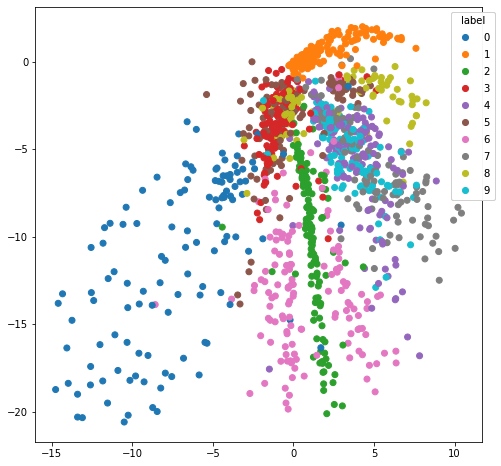


VAE:


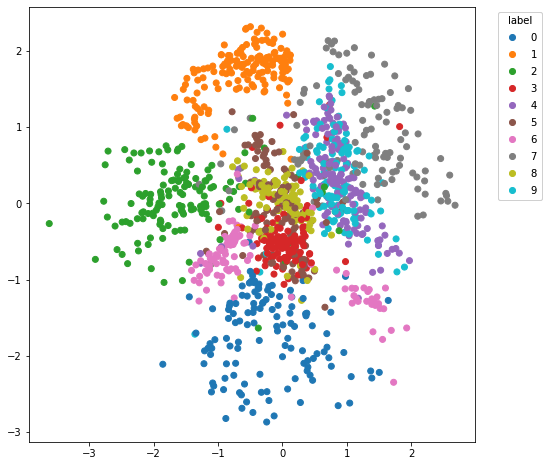

In [54]:
################ Problem 14 (2 pts) ################
# Run the current cell,
# Then answer the following cell's question in the cell itself
####################### End ########################

def visualize_2d(model, n_batch):
    assert model.z_dim == 2
    model.eval()

    n = BATCH_SIZE * n_batch
    Y, Z = torch.zeros(n, dtype=int), torch.zeros((n, model.z_dim))

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            if batch_idx >= n_batch:
                break
            current_range = range(batch_idx * BATCH_SIZE, (batch_idx+1) * BATCH_SIZE)
            Y[current_range] = y
            x = x.flatten(start_dim=1).to(device)
            _, z, _ = model(x)
            Z[current_range] = z.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='tab10')
    legend = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1.04, 1), title="label")
    ax.add_artist(legend)
    plt.show()

print('AE:')
visualize_2d(ae_low_dim, 10)

print('\nVAE:')
visualize_2d(vae_low_dim, 10)

#### Question

<div dir="rtl"> 
دو مدل
<tt>ae_low_dim</tt> 
و 
<tt>vae_low_dim</tt> 
(که هر دوی آن‌ها فضای نهانی به بعد ۲ دارند)
را در نظر بگیرید.
وقتی داده‌ای را به هر یک از این دو مدل ورودی می‌دهیم، هر کدام از آن‌ها پس از انجام عملیات مربوط به بخش
Encoder
خود، توزیع دومتغیره‌ای از نوع گاوسی روی فضای نهان ایجاد می‌کنند. برای تعدادی داده از مجموعه‌ی داده‌های تست میانگین این توزیع‌ها را روی یک نمودار رسم کردیم
(برای هر کدام از دو مدل نامبرده به صورت جداگانه).
در واقع هر کدام از این دو نمودار، نمودار بازنمایی در فضای نهان برای تعدادی داده است. رنگ هر نقطه نیز برچسب داده‌ی مربوط به هر بازنمایی را مشخص می‌کند.

الف) 
به نظر شما کدام مدل فضای نهان بهتری را یاد گرفته‌است؟
(با ذکر دلیل)

ب)
پیشبینی می‌کنید تصاویر میانی در
interpolation
بین دو تصویر، در کدام یک از این دو مدل تصاویر معنی‌دارتری هستند؟ چرا؟
(اگر با
interpolation
آشنایی ندارید، ابتدا آخرین بخش این
notebook
را انجام دهید.)




<b>پاسخ خود را در دو قسمت زیر بنویسید:</b>

الف)
...

ب)
...
</div>

### 5.2) Reconstruction (3 pts)

Data


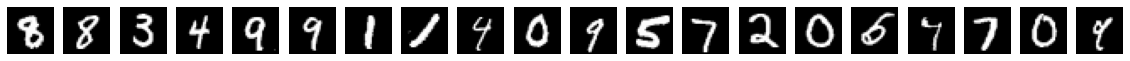

AE 2D


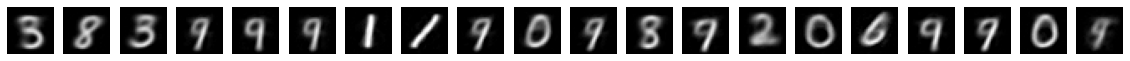

VAE 2D


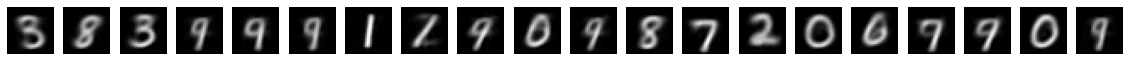

AE 32D


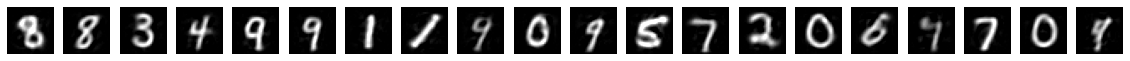

VAE 32D


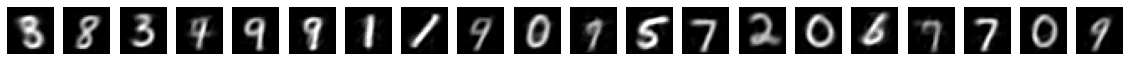

In [55]:
def plot_reconstructions(models, n):
    x = next(iter(test_loader))[0][:n]  # Get a batch and choose `n` of images
    print('Data')
    show(x.squeeze(1))

    x = x.flatten(start_dim=1).to(device)
    for model in models:
        model.eval()
        x_hat, _, _ = model(x)
        print('%s %dD' % (model.type_str, model.z_dim))
        show(x_hat.detach().cpu())

plot_reconstructions(models, 20)

################ Problem 15 (3 pts) ################
# Just run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################

### 5.3) Generation (3 pts)

VAE 32D


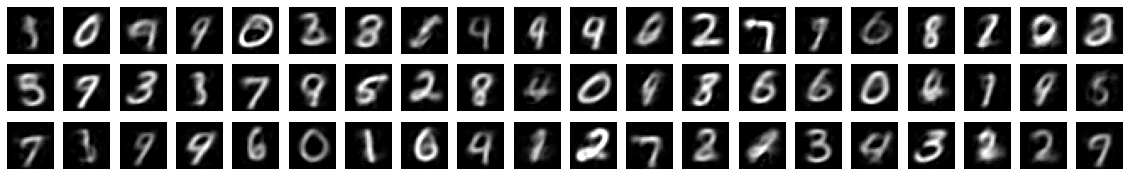

In [56]:
print('VAE %dD' % vae_high_dim.z_dim)
generated_imgs = vae_high_dim.generate(60)
show(generated_imgs.detach().cpu(), 3)

################ Problem 16 (3 pts) ################
# Just run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################

### 5.4) Interpolation (7 pts)

AE 2D


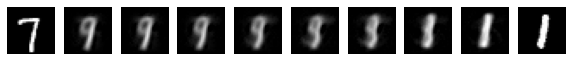

VAE 2D


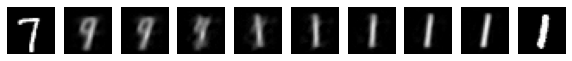

AE 32D


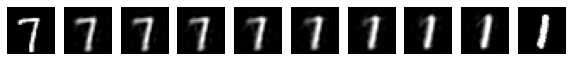

VAE 32D


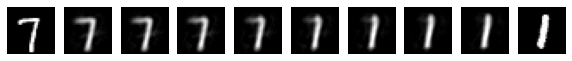

---

AE 2D


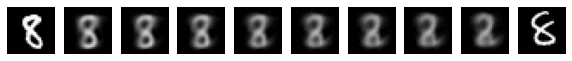

VAE 2D


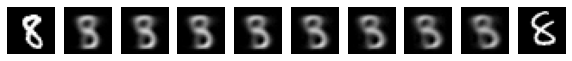

AE 32D


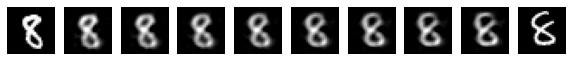

VAE 32D


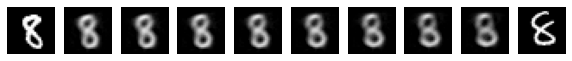

---

AE 2D


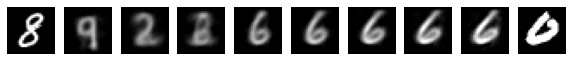

VAE 2D


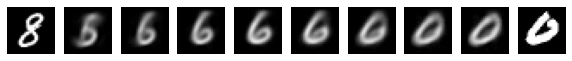

AE 32D


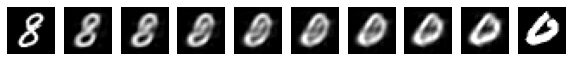

VAE 32D


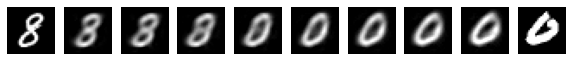

---

AE 2D


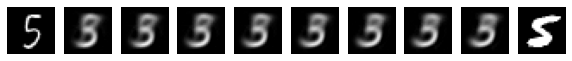

VAE 2D


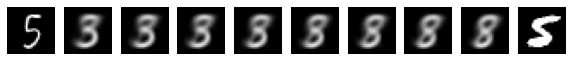

AE 32D


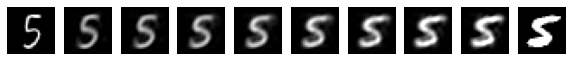

VAE 32D


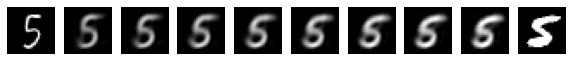

---

AE 2D


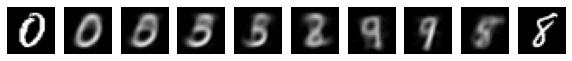

VAE 2D


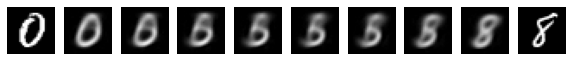

AE 32D


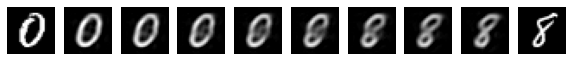

VAE 32D


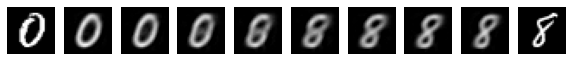

---



In [57]:
def plot_interpolations(models, n_rows, n_cols=10):
    """
    This function interpolates n_cols images between two random MNIST image
    """
    plt.rcParams['figure.figsize'] = (n_cols, n_rows)
    
    x = next(iter(test_loader))[0][:2 * n_rows].flatten(start_dim=1).to(device)
    for i in range(n_rows):
        img1 = x[2 * i]
        img2 = x[2 * i + 1]
        
        for model in models:
            model.eval()
            images = None
            ################ Problem 17 (5 pts) ################
            # Find the representations of `img1, img2` in the latent space and call them `z1, z2`
            # Interpolate `n_cols` tensors (evenly spaced) between `z1` and `z2` (including both)
            # Feed these tensors to the decoder and get the resulting reconstruced images
            # Store these `n_cols` images in `images[1:-1]`
            # Set `images[0], images[-1]` to `img1, img2` respectively
            # Prepare `images` tensor to be passed into `show` function
            _, z1, _ = model(img1)
            _, z2, _ = model(img2)

            diff = (z2 - z1) / (n_cols - 1)
            z_interpolate = torch.tensor([], device=device)
            
            for j in range(1, n_cols - 1):
                z_interpolate = torch.cat((z_interpolate, z1 + j * diff))
            
            z_interpolate = z_interpolate.reshape(-1, model.z_dim)
            interpolated_images = model.decoder(z_interpolate)

            images = torch.cat((img1, *interpolated_images, img2)).reshape(-1, 784)
            images = images.detach().cpu()
            
            pass
            ####################### End ########################
            print('%s %dD' % (model.type_str, model.z_dim))
            show(images)
        print('---\n')

plot_interpolations(models, 5)

################ Problem 18 (2 pts) ################
# Run this cell, make sure the output is saved in the uploaded notebook
####################### End ########################